# Time Series Analisys Appply to Finance in RTRS Certified Players

In [1]:
import pandas as pd 
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import pmdarima as pm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import grangercausalitytests
from pathlib import Path
from datetime import datetime
from fuzzywuzzy import process
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [2]:
current_file_path = Path.cwd()
root = current_file_path.parent

external_path = root / 'data' / 'external_data' 
processed_path = root / 'data'/ 'processed_data'

In [3]:
rtrs_data = pd.read_csv(processed_path / 'brazil_rtrs.csv', encoding = 'iso-8859-14', decimal=',')
farm_branches = pd.read_csv(processed_path / 'farm_branches.csv', usecols = ['State', 'City', 'Organization'])
b3_data = pd.read_csv(external_path / 'acoes-listadas-b3.csv')
trase = pd.read_excel(external_path / 'trase_soy_2-6-0.xlsx')

In [4]:
rtrs_data['Organization'].unique()

array(['Cataratas do Iguaçu Produtos Orgânicos',
       'Fundação de Apoio à Pesquisa do Corredor de Exportação Norte ?Irineu Alcides Bays',
       'Fazenda Santa Cruz', 'Serra da Pintura',
       'Tecnosol Consultoria Rural', 'Agropecuaria Andrade', 'GGF Agro',
       'Archer-Daniels-Midland Company (ADM)',
       'Cerquality Consultoria em Sustentabilidade e Certificação',
       'GMS Agronegócio ', 'Produzindo Certo ?Grupo Castrolanda',
       'Girassol Agrícola', 'Fazenda Modelo', 'Agropastoril Jotabasso',
       'Amaggi', 'Aliança da Terra', 'Grupo Hervalense',
       'Grupo de Produtores CJ Selecta',
       'Wellington Pereira Lima - Gebana Goias',
       'Saag Comercial Exportadora ', 'SLC Agrícola',
       'Louis Dreyfus Company ', 'Associação Clube Amigos da Terra ',
       'Grupo Reinhofer', 'Fazenda Pau Furado', 'Bunge',
       'Fazenda Pirulito', 'Fazenda São João Batista', 'AgroSB',
       'Fazenda Nossa Senhora Aparecida', 'Bom Jesus Agropecuaria ',
       'Fazenda Lagoa 

In [5]:
b3_data['Nome'].unique()

array(['Hapvida', 'Banco Bradesco', 'Magazine Luiza', 'Oi', 'MRV',
       'Itaú Unibanco', 'Cogna', 'B3', 'Cielo', 'Lojas Renner', 'Vale',
       'Petrobras', 'Itaúsa', 'Ambev', 'Azul', 'Petz', 'Americanas',
       'Totvs', 'Usiminas', 'CVC', 'Marcopolo', 'Copel', 'Rumo',
       'Equatorial Energia', 'CEMIG', 'Natura', 'Assaí', 'Grupo Soma',
       'Cosan', 'Casas Bahia', 'GOL', 'Alpargatas', 'Banco do Brasil',
       'Minerva', 'Grupo CCR', 'BB Seguridade', 'Sequoia Logística',
       'Gafisa', 'Eletrobras', 'VTRM ENERGIA PARTICIPAÃiES S.A.',
       'Raízen', 'Caixa Seguridade', 'Grupo Vamos', 'Carrefour Brasil',
       'Cyrela', 'C&A', 'Santos Brasil', 'Infracommerce', 'TIM',
       '3R Petroleum', 'Grupo Mateus', 'Ânima Educação', 'Locaweb',
       'Grupo Pão de Açúcar', 'PetroRio', 'Siderúrgica Nacional',
       'Gerdau', 'Eneva', 'Localiza', 'AES Brasil', 'RaiaDrogasil',
       'Vibra Energia', 'BRF', 'CSN Mineração', 'Qualicorp', 'Suzano',
       'Metalúrgica Gerdau', 'Ultrapar',

In [6]:
trase['EXPORTER GROUP'].unique()

array(['DOMESTIC CONSUMPTION', 'CARGILL',
       'SHANGHAI PENGXIN GROUP CO., LTD.', ..., 'BAYER CROPSCIENCE LTDA',
       'FAZENDAS BUTIA AGROPECUARIA', 'PMG AGRICOLA COMERCIAL LTDA'],
      dtype=object)

## Similarity FuzzyWuzzy

In [7]:
def find_similarities(list1, list2, limit=75):
    """
    Finds similar strings between two lists using FuzzyWuzzy.
    
    Parameters:
    - list1: List of strings to compare with the second list.
    - list2: List of strings against which the first list will be compared.
    - threshold: Similarity threshold for considering a string as a match (default 75).
    
    Returns:
    - A list of tuples containing the string from list1, the most similar string from list2 and the similarity score.
    """
    
    similar_results = []

    for item in list1:
        # Find the best match for 'item' in 'list2'
        best_match, score = process.extractOne(item, list2)
        
        # Check if the similarity is above the defined threshold
        if score >= limit:
            similar_results.append(best_match)
            
    return similar_results

In [8]:
#Similarity between B3 and RTRS

sim_ts = find_similarities(b3_data['Nome'].unique().tolist(), rtrs_data['Organization'].unique().tolist(), limit=95)
print(sim_ts)

['SLC Agrícola']


In [9]:
farm_branches.dropna(inplace=True)

- Just 1 company found? Yes

In [10]:
#Similarity between Trase and RTRS

amazon_states = [
    "ACRE",
    "AMAPA",
    "AMAZONAS",
    "MARANHAO",
    "MATO GROSSO",
    "PARA",
    "RONDONIA",
    "RORAIMA",
    "TOCANTINS"
]

trase = trase[trase['STATE'].isin(amazon_states)]
rtrs_groups = find_similarities(rtrs_data['Organization'].unique().tolist(), trase['EXPORTER GROUP'].unique().tolist(), limit=93)
rtrs_groups.append('ADM')
rtrs_groups.append('SLC')
trase['IS_RTRS'] = trase['EXPORTER GROUP'].apply(lambda x: 1 if x in rtrs_groups else 0)

In [11]:
trase[['EXPORTER GROUP', 'IS_RTRS']]

,EXPORTER GROUP,IS_RTRS
0,DOMESTIC CONSUMPTION,0
1,DOMESTIC CONSUMPTION,0
2,DOMESTIC CONSUMPTION,0
3,CARGILL,0
4,CARGILL,0
...,...,...
283780,GIRASSOL AGRICOLA,1
283781,GIRASSOL AGRICOLA,1
283782,GIRASSOL AGRICOLA,1
283783,GIRASSOL AGRICOLA,1


## Finance Analysis

In [12]:
rtrs_slc_data = rtrs_data[rtrs_data['Organization'].isin(['SLC Agrícola', 'Bunge', 'Archer-Daniels-Midland Company (ADM)'])]

In [13]:
rtrs_slc_data[['Issue_Date', 'Expiration_Date']]

,Issue_Date,Expiration_Date
7,27/01/23,26/01/28
22,23/09/21,23/09/26
23,20/09/22,15/09/27
26,14/07/22,14/07/27
31,05/07/22,31/03/27
58,23/09/21,23/09/26
77,18/08/16,17/08/21
78,17/08/17,17/08/21
105,17/08/17,17/08/21
120,31/01/18,30/01/23


In [14]:
data_dict = {
    'Bunge': 
            {'Ticker':'BG', 
              'IssueDate': None,
               'ExpiredDate': None}, 
    'Soy Sector': {'Ticker':'ZS=F',
                   'IssueDate': '01/03/06', #RTRS Founded
                   'ExpiredDate': '31/12/23'}, 
    'Archer-Daniels-Midland Company (ADM)': {'Ticker': 'ADM',
            'IssueDate': None,
            'ExpiredDate': None}, 
    'SLC Agrícola': {'Ticker': 'SLCJY',
                  'IssueDate': None,
                  'ExpiredDate': None},
}

for organization in data_dict.keys():
    filtered_data = rtrs_data[rtrs_data['Organization'] == organization]

    if not filtered_data.empty:
        issue_dates = filtered_data['Issue_Date'].tolist()
        expired_dates = filtered_data['Expiration_Date'].tolist()

        if 'IssueDate' in data_dict[organization]:
            data_dict[organization]['IssueDate'] = issue_dates if len(issue_dates) > 1 else issue_dates[0]

        if 'ExpiredDate' in data_dict[organization]:
            data_dict[organization]['ExpiredDate'] = expired_dates if len(expired_dates) > 1 else expired_dates[0]

In [15]:
data_dict

{'Bunge': {'Ticker': 'BG', 'IssueDate': '05/07/22', 'ExpiredDate': '31/03/27'},
 'Soy Sector': {'Ticker': 'ZS=F',
  'IssueDate': '01/03/06',
  'ExpiredDate': '31/12/23'},
 'Archer-Daniels-Midland Company (ADM)': {'Ticker': 'ADM',
  'IssueDate': ['27/01/23', '20/09/22'],
  'ExpiredDate': ['26/01/28', '15/09/27']},
 'SLC Agrícola': {'Ticker': 'SLCJY',
  'IssueDate': ['23/09/21',
   '14/07/22',
   '23/09/21',
   '18/08/16',
   '17/08/17',
   '17/08/17',
   '31/01/18'],
  'ExpiredDate': ['23/09/26',
   '14/07/27',
   '23/09/26',
   '17/08/21',
   '17/08/21',
   '17/08/21',
   '30/01/23']}}

In [16]:
data_list = list()

#to get the finance data
for org, value in data_dict.items():
    data = yf.Ticker(value['Ticker'])
    data = data.history(period='max').reset_index('Date') 
    data['Date'] = pd.to_datetime(data['Date']) #You can change for '1d', '1mo', '1y' etc.
    data_list.append(data)

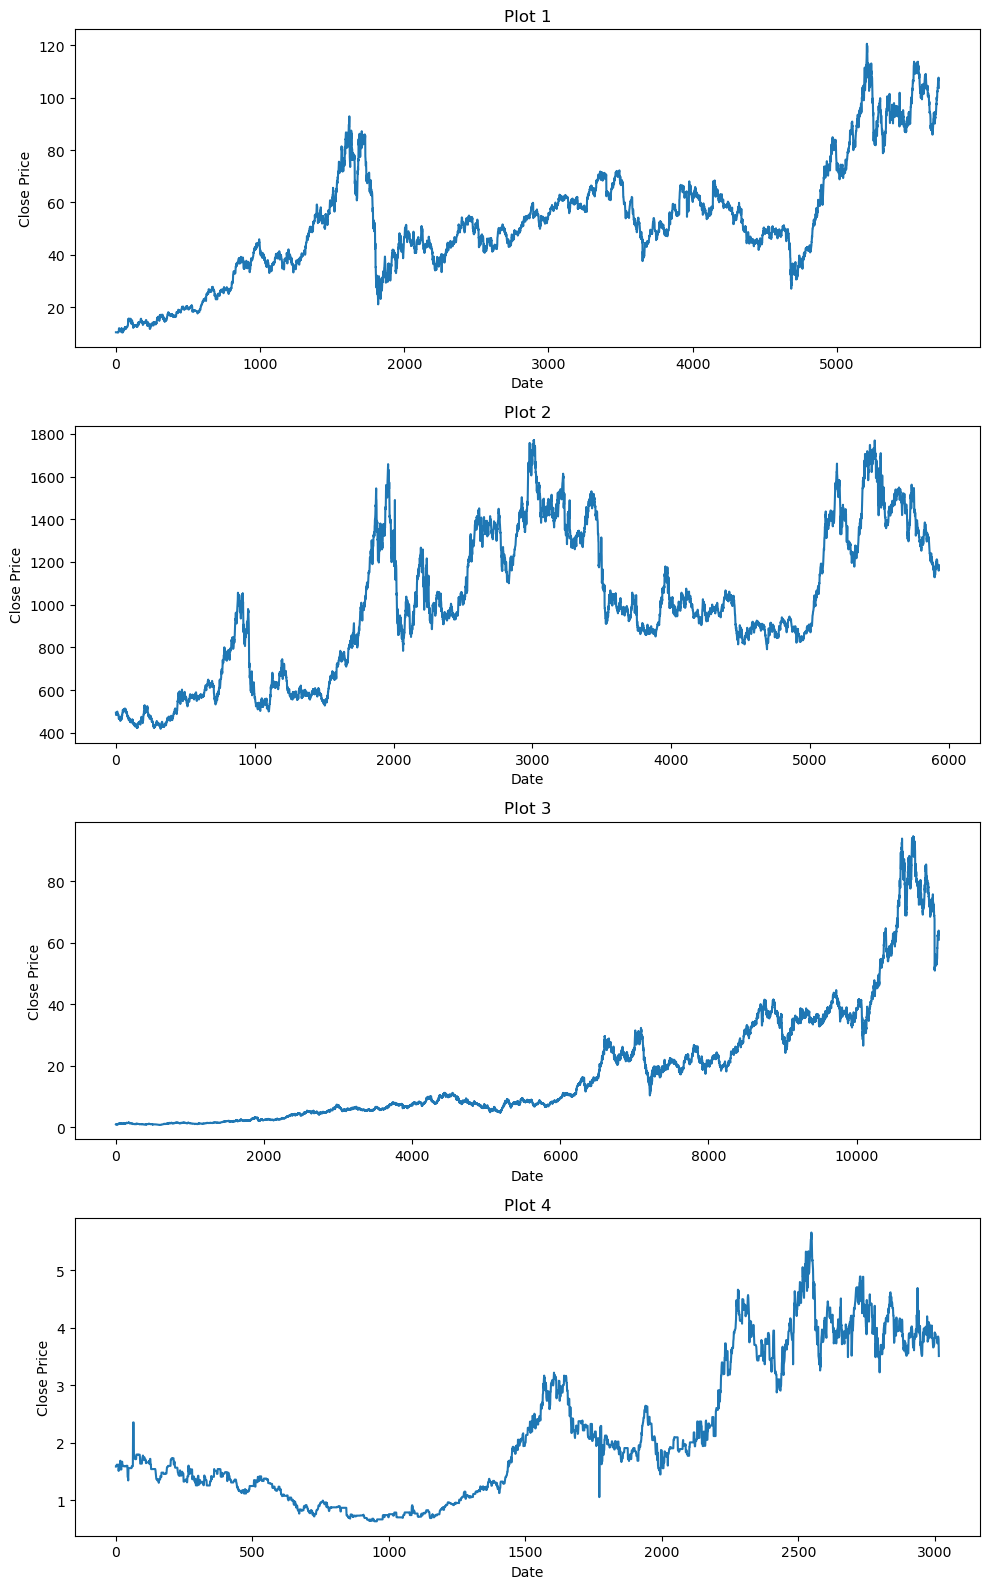

In [17]:
fig, axs = plt.subplots(len(data_list), 1, figsize=(10, 4 * len(data_list)))

if not isinstance(axs, np.ndarray):
    axs = [axs]

for idx, ax in enumerate(axs):
    data_list[idx]['Close'].plot(ax=ax)  
    ax.set_title(f'Plot {idx + 1}')  
    ax.set_xlabel('Date')  
    ax.set_ylabel('Close Price') 
plt.tight_layout()  
plt.show()  

In [18]:
date_limit = datetime.strptime('10/02/2024', '%d/%m/%Y')

def correct_date_format(date_input):
    if isinstance(date_input, list):
        return [datetime.strptime(date, '%d/%m/%y').strftime('%d/%m/%Y') for date in date_input]
    elif isinstance(date_input, str):
        return datetime.strptime(date_input, '%d/%m/%y').strftime('%d/%m/%Y')
    else:
        return None

for key, value in data_dict.items():
    if 'IssueDate' in value and value['IssueDate'] is not None:
        value['IssueDate'] = correct_date_format(value['IssueDate'])
    if 'ExpiredDate' in value and value['ExpiredDate'] is not None:
        value['ExpiredDate'] = correct_date_format(value['ExpiredDate'])

In [19]:
def convert_to_datetime(date_str):
    """Converte uma string para datetime, considerando o formato '%d/%m/%Y'."""
    if isinstance(date_str, str):
        try:
            return datetime.strptime(date_str, '%d/%m/%Y')
        except ValueError:
            # Log ou lidar com a exceção conforme necessário
            pass
    return date_str

def remove_timezone(dt):
    """Remove timezone information from a datetime object, making it tz-naive."""
    if dt is not None and not isinstance(dt, str):
        return dt.replace(tzinfo=None)
    return dt

for org, info in data_dict.items():
    if isinstance(info['IssueDate'], list):
        info['IssueDate'] = [remove_timezone(convert_to_datetime(dt)) for dt in info['IssueDate']]
    else:
        info['IssueDate'] = remove_timezone(convert_to_datetime(info['IssueDate']))
    
    if isinstance(info['ExpiredDate'], list):
        info['ExpiredDate'] = [remove_timezone(convert_to_datetime(dt)) for dt in info['ExpiredDate']]
    else:
        info['ExpiredDate'] = remove_timezone(convert_to_datetime(info['ExpiredDate']))

# Aplicar a remoção de fuso horário nas datas de IssueDate e ExpiredDate
for org, info in data_dict.items():
    if isinstance(info['IssueDate'], list):
        info['IssueDate'] = [remove_timezone(dt) for dt in info['IssueDate']]
    else:
        info['IssueDate'] = remove_timezone(info['IssueDate'])
    
    if isinstance(info['ExpiredDate'], list):
        info['ExpiredDate'] = [remove_timezone(dt) for dt in info['ExpiredDate']]
    else:
        info['ExpiredDate'] = remove_timezone(info['ExpiredDate'])

def update_dummy_columns(df, issue_date, expired_date, dummy_column_name):
    df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)
    
    df[dummy_column_name] = ((df['Date'] >= issue_date) & (df['Date'] <= expired_date)).astype(int)

for i, (org, info) in enumerate(data_dict.items()):
    df = data_list[i]  
    issue_dates = info['IssueDate']
    expired_dates = info['ExpiredDate']
    
    if issue_dates is None or expired_dates is None:
        continue
    
    if not isinstance(issue_dates, list):
        issue_dates = [issue_dates]
    if not isinstance(expired_dates, list):
        expired_dates = [expired_dates]
    
    for j, (issue_date, expired_date) in enumerate(zip(issue_dates, expired_dates)):
        if issue_date and expired_date and issue_date <= date_limit:
            dummy_column_name = f'{org.replace(" ", "_")}_Period_{j+1}'
            df[dummy_column_name] = 0  
            update_dummy_columns(df, issue_date, expired_date, dummy_column_name)

In [20]:
data_list[0].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Bunge_Period_1'],
      dtype='object')

In [21]:
# Soy sector OLS Analysis

Y = data_list[1]['Close']
X = data_list[1][['Soy_Sector_Period_1']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

p_value = model.pvalues['Soy_Sector_Period_1']

print(f'p-value about Soy_Sector_Period_1 is {p_value}')

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     4339.
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:07:34   Log-Likelihood:                -41290.
No. Observations:                5930   AIC:                         8.258e+04
Df Residuals:                    5928   BIC:                         8.260e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 618.1060    

In [22]:
#Bunge OLS Analysis

Y = data_list[0]['Close']
X = data_list[0][['Bunge_Period_1']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

p_value = model.pvalues['Bunge_Period_1']

print(f'p-value about Bunge_Period_1 is {p_value}')

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     2781.
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:07:34   Log-Likelihood:                -24709.
No. Observations:                5709   AIC:                         4.942e+04
Df Residuals:                    5707   BIC:                         4.943e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             48.5333      0.253    191.

In [23]:
#ADM OLS Analysis

Y = data_list[2]['Close']
X = data_list[2][['Archer-Daniels-Midland_Company_(ADM)_Period_1', 'Archer-Daniels-Midland_Company_(ADM)_Period_2']]
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     2623.
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:07:34   Log-Likelihood:                -46564.
No. Observations:               11112   AIC:                         9.313e+04
Df Residuals:                   11109   BIC:                         9.316e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [24]:
#SLC OLS Analysis

Y = data_list[3]['Close']
X = data_list[3][['SLC_Agrícola_Period_1', 
                  'SLC_Agrícola_Period_2',
                  'SLC_Agrícola_Period_3', 
                  'SLC_Agrícola_Period_4',
                  'SLC_Agrícola_Period_5', 
                  'SLC_Agrícola_Period_6',
                  'SLC_Agrícola_Period_7']]

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     2605.
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:07:34   Log-Likelihood:                -2403.1
No. Observations:                3016   AIC:                             4818.
Df Residuals:                    3010   BIC:                             4854.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.19

## How much does the variation in soy have an impact on the variation in the shares of those companies that don't only work in soy retail?

In [25]:
soy_closed = data_list[1]['Close'].copy(deep=True)
bunge_closed = data_list[0]['Close'].copy(deep=True)
adm_closed = data_list[2]['Close'].copy(deep=True)
slc_closed = data_list[3]['Close'].copy(deep=True)
date = data_list[1]['Date'].copy(deep=True)

df = pd.DataFrame({'Data': date, 
                   'bunge': bunge_closed, 
                   'adm': adm_closed,
                   'slc': slc_closed,
                   'soy': soy_closed})

In [26]:
df.dropna(inplace=True)

In [27]:
sc = StandardScaler()

df[['bunge', 'adm', 'slc', 'soy']] = sc.fit_transform(df[['bunge', 'adm', 'slc', 'soy']])

In [28]:
df.head()

,Data,bunge,adm,slc,soy
0,2000-09-15,-1.726416,-0.951116,-0.459380,-1.070739
1,2000-09-18,-1.726416,-0.931265,-0.459380,-1.099949
2,2000-09-19,-1.726416,-0.922758,-0.459380,-1.099200
3,2000-09-20,-1.726416,-0.905742,-0.433718,-1.102196
4,2000-09-21,-1.726416,-0.922758,-0.433718,-1.092459


In [29]:
corr = df.corr()
print("Correlations:")
print(corr)

Correlations:
          bunge       adm       slc       soy
bunge  1.000000  0.467624  0.456566  0.408542
adm    0.467624  1.000000  0.875683  0.849154
slc    0.456566  0.875683  1.000000  0.692925
soy    0.408542  0.849154  0.692925  1.000000


In [30]:
for enterprise in df[['bunge', 'adm', 'slc']]:
    X = df[['soy']]  
    y = df[enterprise]  

    model = LinearRegression()
    model.fit(X, y)
    
    print('Enterprise:', enterprise)
    print("Coefficient (slopee):", model.coef_)
    print("Intercept:", model.intercept_)
    print()


# The coefficient indicates how much the variation in the company is affected by the variation in the soy sector.

Enterprise: bunge
Coefficient (slopee): [0.4085425]
Intercept: -5.148438170683184e-17

Enterprise: adm
Coefficient (slopee): [0.84915428]
Intercept: 2.0342318722286437e-16

Enterprise: slc
Coefficient (slopee): [0.69292489]
Intercept: 2.5525633621936276e-16



- These coefficients suggest a positive relationship between variations in the assets of the soy sector and the assets of the companies specified. For example, the coefficient of 0.83258369 indicates that for each unit increase in the variation of the soy sector, an increase of 0.83258369 units is expected in the variation of the corresponding asset, all other variables remaining constant.

- Intercepts close to zero in standardized models (where the data has been centered and scaled) are expected, as they indicate that the prediction is zero when all the independent variables are zero. In contexts where the data has not been centered, the intercept represents the prediction for the dependent variable when all the independent variables are zero.


# Time Series

In [31]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox


In [32]:
max_lags = 15

In [33]:
#Soy Sector
test = grangercausalitytests(data_list[1][['Close', 'Soy_Sector_Period_1']], max_lags, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5204  , p=0.0188  , df_denom=5926, df_num=1
ssr based chi2 test:   chi2=5.5232  , p=0.0188  , df=1
likelihood ratio test: chi2=5.5206  , p=0.0188  , df=1
parameter F test:         F=5.5204  , p=0.0188  , df_denom=5926, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8831  , p=0.0560  , df_denom=5923, df_num=2
ssr based chi2 test:   chi2=5.7712  , p=0.0558  , df=2
likelihood ratio test: chi2=5.7684  , p=0.0559  , df=2
parameter F test:         F=2.8831  , p=0.0560  , df_denom=5923, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9138  , p=0.1250  , df_denom=5920, df_num=3
ssr based chi2 test:   chi2=5.7481  , p=0.1245  , df=3
likelihood ratio test: chi2=5.7453  , p=0.1247  , df=3
parameter F test:         F=1.9138  , p=0.1250  , df_denom=5920, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4458  , p=0.

/home/cleyton/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=0.7680  , p=0.6600  , df_denom=5899, df_num=10
ssr based chi2 test:   chi2=7.7075  , p=0.6574  , df=10
likelihood ratio test: chi2=7.7025  , p=0.6579  , df=10
parameter F test:         F=0.7680  , p=0.6600  , df_denom=5899, df_num=10

Granger Causality
number of lags (no zero) 11
ssr based F test:         F=0.8096  , p=0.6306  , df_denom=5896, df_num=11
ssr based chi2 test:   chi2=8.9408  , p=0.6274  , df=11
likelihood ratio test: chi2=8.9341  , p=0.6280  , df=11
parameter F test:         F=0.8096  , p=0.6306  , df_denom=5896, df_num=11

Granger Causality
number of lags (no zero) 12
ssr based F test:         F=0.7871  , p=0.6644  , df_denom=5893, df_num=12
ssr based chi2 test:   chi2=9.4857  , p=0.6610  , df=12
likelihood ratio test: chi2=9.4781  , p=0.6616  , df=12
parameter F test:         F=0.7871  , p=0.6644  , df_denom=5893, df_num=12

Granger Causality
number of lags (no zero) 13
ssr based F test:         F=0.7236  , p=0.7415  , df_denom=5890, df_num=1

- In the soy sector as a whole, the impact of certification was only felt in the short term

In [34]:
#Bunge
test = grangercausalitytests(data_list[0][['Close', 'Bunge_Period_1']], max_lags, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5543  , p=0.0594  , df_denom=5705, df_num=1
ssr based chi2 test:   chi2=3.5562  , p=0.0593  , df=1
likelihood ratio test: chi2=3.5551  , p=0.0594  , df=1
parameter F test:         F=3.5543  , p=0.0594  , df_denom=5705, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1044  , p=0.1220  , df_denom=5702, df_num=2
ssr based chi2 test:   chi2=4.2125  , p=0.1217  , df=2
likelihood ratio test: chi2=4.2109  , p=0.1218  , df=2
parameter F test:         F=2.1044  , p=0.1220  , df_denom=5702, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3056  , p=0.0194  , df_denom=5699, df_num=3
ssr based chi2 test:   chi2=9.9291  , p=0.0192  , df=3
likelihood ratio test: chi2=9.9205  , p=0.0193  , df=3
parameter F test:         F=3.3056  , p=0.0194  , df_denom=5699, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6839  , p=0.

- For Bunge, the effects of certification are causal in the long term

In [35]:
#ADM

test = grangercausalitytests(data_list[2][['Close', 'Archer-Daniels-Midland_Company_(ADM)_Period_1']], max_lags, verbose=True)
test = grangercausalitytests(data_list[2][['Close', 'Archer-Daniels-Midland_Company_(ADM)_Period_2']], max_lags, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5992  , p=0.0058  , df_denom=11108, df_num=1
ssr based chi2 test:   chi2=7.6012  , p=0.0058  , df=1
likelihood ratio test: chi2=7.5986  , p=0.0058  , df=1
parameter F test:         F=7.5992  , p=0.0058  , df_denom=11108, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.2025  , p=0.0003  , df_denom=11105, df_num=2
ssr based chi2 test:   chi2=16.4124 , p=0.0003  , df=2
likelihood ratio test: chi2=16.4003 , p=0.0003  , df=2
parameter F test:         F=8.2025  , p=0.0003  , df_denom=11105, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1526  , p=0.0004  , df_denom=11102, df_num=3
ssr based chi2 test:   chi2=18.4695 , p=0.0004  , df=3
likelihood ratio test: chi2=18.4542 , p=0.0004  , df=3
parameter F test:         F=6.1526  , p=0.0004  , df_denom=11102, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.9543  

- For ADM, its two certifications have been influential in the short, medium and long term.

In [36]:
test = grangercausalitytests(data_list[3][['Close', 'SLC_Agrícola_Period_1']], max_lags, verbose=True)
print()
test = grangercausalitytests(data_list[3][['Close', 'SLC_Agrícola_Period_2']], max_lags, verbose=True)
print()
test = grangercausalitytests(data_list[3][['Close', 'SLC_Agrícola_Period_2']], max_lags, verbose=True)
print()
test = grangercausalitytests(data_list[3][['Close', 'SLC_Agrícola_Period_3']], max_lags, verbose=True)
print()
test = grangercausalitytests(data_list[3][['Close', 'SLC_Agrícola_Period_4']], max_lags, verbose=True)
print()
test = grangercausalitytests(data_list[3][['Close', 'SLC_Agrícola_Period_5']], max_lags, verbose=True)
print()
test = grangercausalitytests(data_list[3][['Close', 'SLC_Agrícola_Period_6']], max_lags, verbose=True)
print()
test = grangercausalitytests(data_list[3][['Close', 'SLC_Agrícola_Period_7']], max_lags, verbose=True)
print()


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4554  , p=0.0349  , df_denom=3012, df_num=1
ssr based chi2 test:   chi2=4.4598  , p=0.0347  , df=1
likelihood ratio test: chi2=4.4565  , p=0.0348  , df=1
parameter F test:         F=4.4554  , p=0.0349  , df_denom=3012, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3492  , p=0.2596  , df_denom=3009, df_num=2
ssr based chi2 test:   chi2=2.7030  , p=0.2589  , df=2
likelihood ratio test: chi2=2.7018  , p=0.2590  , df=2
parameter F test:         F=1.3492  , p=0.2596  , df_denom=3009, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7765  , p=0.5070  , df_denom=3006, df_num=3
ssr based chi2 test:   chi2=2.3349  , p=0.5059  , df=3
likelihood ratio test: chi2=2.3340  , p=0.5060  , df=3
parameter F test:         F=0.7765  , p=0.5070  , df_denom=3006, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6827  , p=0.

- For SLC Agrícola, its seven certificates have been influential in the long term.

## Market-Share Analysis


In [37]:
trase.columns

Index(['YEAR', 'COUNTRY OF PRODUCTION', 'BIOME', 'STATE',
       'MUNICIPALITY OF PRODUCTION', 'LOGISTICS HUB', 'PORT OF EXPORT',
       'EXPORTER', 'EXPORTER GROUP', 'IMPORTER', 'IMPORTER GROUP',
       'COUNTRY OF FIRST IMPORT', 'ECONOMIC BLOC', 'TYPE',
       'Soy deforestation exposure', 'FOB_USD',
       'CO2_GROSS_EMISSIONS_SOY_DEFORESTATION_5_YEAR_TOTAL_EXPOSURE',
       'SOY_EQUIVALENT_TONNES', 'LAND_USE_HA',
       'CO2_NET_EMISSIONS_SOY_DEFORESTATION_5_YEAR_TOTAL_EXPOSURE',
       'Soy deforestation risk', 'ZERO_DEFORESTATION_BRAZIL_SOY',
       'TRASE_GEOCODE', 'IS_RTRS'],
      dtype='object')

In [38]:
trase = trase[['EXPORTER GROUP','Soy deforestation exposure', 'FOB_USD', 'CO2_GROSS_EMISSIONS_SOY_DEFORESTATION_5_YEAR_TOTAL_EXPOSURE',
               'SOY_EQUIVALENT_TONNES', 'LAND_USE_HA', 'CO2_NET_EMISSIONS_SOY_DEFORESTATION_5_YEAR_TOTAL_EXPOSURE',
               'Soy deforestation risk', 'IS_RTRS', 'STATE','MUNICIPALITY OF PRODUCTION', 'YEAR']]

In [39]:
trase.rename(columns={'EXPORTER GROUP': 'Group', 
                      'Soy deforestation exposure': 'SoyDefExp',
                      'FOB_USD': 'ExpFOB',
                      'CO2_GROSS_EMISSIONS_SOY_DEFORESTATION_5_YEAR_TOTAL_EXPOSURE': 'CO2Gross',
                      'SOY_EQUIVALENT_TONNES': 'SoyTonnes',
                      'LAND_USE_HA': 'LandUse',
                      'CO2_NET_EMISSIONS_SOY_DEFORESTATION_5_YEAR_TOTAL_EXPOSURE': 'CO2Net',
                      'Soy deforestation risk': 'SoyRisk',
                      'IS_RTRS': 'IsRTRS' ,
                      'STATE': 'State',
                      'MUNICIPALITY OF PRODUCTION': 'City',
                      'YEAR': 'Year'
                      }, inplace=True)

In [40]:
trase['Yield'] = trase['SoyTonnes'] / trase['LandUse']

In [41]:
trase.head()

,Group,SoyDefExp,ExpFOB,CO2Gross,SoyTonnes,LandUse,CO2Net,SoyRisk,IsRTRS,State,City,Year,Yield
0,DOMESTIC CONSUMPTION,0.0,0.000000,0.0,81.000000,27.000000,0.0,0.0,0,ACRE,CAPIXABA,2017,3.000
1,DOMESTIC CONSUMPTION,0.0,0.000000,0.0,1279.882771,496.078593,0.0,0.0,0,ACRE,CAPIXABA,2019,2.580
2,DOMESTIC CONSUMPTION,0.0,0.000000,0.0,1500.000000,480.000000,0.0,0.0,0,ACRE,CAPIXABA,2020,3.125
3,CARGILL,0.0,31812.773141,0.0,83.358068,26.049396,0.0,0.0,0,ACRE,CAPIXABA,2018,3.200
4,CARGILL,0.0,23971.251881,0.0,59.739949,18.668734,0.0,0.0,0,ACRE,CAPIXABA,2018,3.200


## Exploratory Analysis

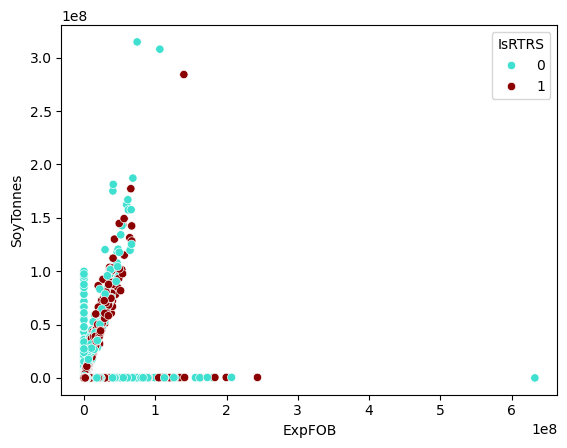

In [42]:
palette = {0: 'turquoise', 1: '#8B0000'}

sns.scatterplot(data=trase, x='ExpFOB', y='SoyTonnes', hue='IsRTRS', palette=palette)

plt.show()

In [43]:
trase[trase['IsRTRS'] == 1].describe()

,SoyDefExp,ExpFOB,CO2Gross,SoyTonnes,LandUse,CO2Net,SoyRisk,IsRTRS,Year,Yield
count,15214.000000,2.408000e+04,1.521400e+04,2.408000e+04,2.408000e+04,1.521400e+04,15214.000000,24080.0,24080.000000,24080.000000
mean,38.892808,2.658461e+06,8.204591e+03,9.608224e+05,1.232961e+04,7.470354e+03,17.873241,1.0,2014.044228,203.388976
std,191.803926,7.711802e+06,3.520582e+04,6.710911e+06,3.589111e+05,3.200750e+04,95.459466,0.0,5.063252,760.709305
min,0.000000,4.667379e+03,0.000000e+00,2.800000e+01,7.211888e+00,0.000000e+00,0.000000,1.0,2004.000000,0.002000
25%,0.197451,8.712624e+04,4.724582e+01,2.503348e+02,7.879133e+01,4.280033e+01,0.096700,1.0,2010.000000,2.940018
50%,1.689982,4.282012e+05,3.919722e+02,1.253508e+03,3.798716e+02,3.537242e+02,0.764563,1.0,2015.000000,3.120000
75%,12.092259,1.937277e+06,2.911110e+03,6.390966e+03,1.680193e+03,2.646162e+03,5.411019,1.0,2019.000000,3.360000
max,7924.061109,2.434312e+08,1.206605e+06,2.842882e+08,3.078161e+07,1.061198e+06,4438.315033,1.0,2020.000000,3720.000000


In [44]:
trase[trase['IsRTRS'] == 0].describe()

,SoyDefExp,ExpFOB,CO2Gross,SoyTonnes,LandUse,CO2Net,SoyRisk,IsRTRS,Year,Yield
count,34574.000000,3.976300e+04,3.457400e+04,3.976300e+04,3.976300e+04,3.457400e+04,34574.000000,39763.0,39763.000000,39763.000000
mean,36.384686,1.421238e+06,7.470840e+03,4.885414e+05,8.437581e+03,6.785799e+03,16.294839,0.0,2017.069638,113.168578
std,252.702996,6.236386e+06,4.725328e+04,5.370091e+06,5.073450e+05,4.302435e+04,115.504757,0.0,3.769522,573.271700
min,0.000000,0.000000e+00,0.000000e+00,2.800000e+01,7.044196e+00,0.000000e+00,0.000000,0.0,2004.000000,0.001710
25%,0.093178,3.259043e+04,2.215998e+01,1.127883e+02,3.489734e+01,1.998769e+01,0.046769,0.0,2015.000000,3.000000
50%,0.760521,1.352667e+05,1.883341e+02,4.686972e+02,1.427612e+02,1.703523e+02,0.364557,0.0,2019.000000,3.240000
75%,5.881518,7.287665e+05,1.513545e+03,2.670142e+03,7.652987e+02,1.383312e+03,2.788469,0.0,2020.000000,3.450000
max,9032.245172,6.325281e+08,2.737455e+06,3.148354e+08,9.350598e+07,2.615397e+06,5448.644685,0.0,2020.000000,3940.000000


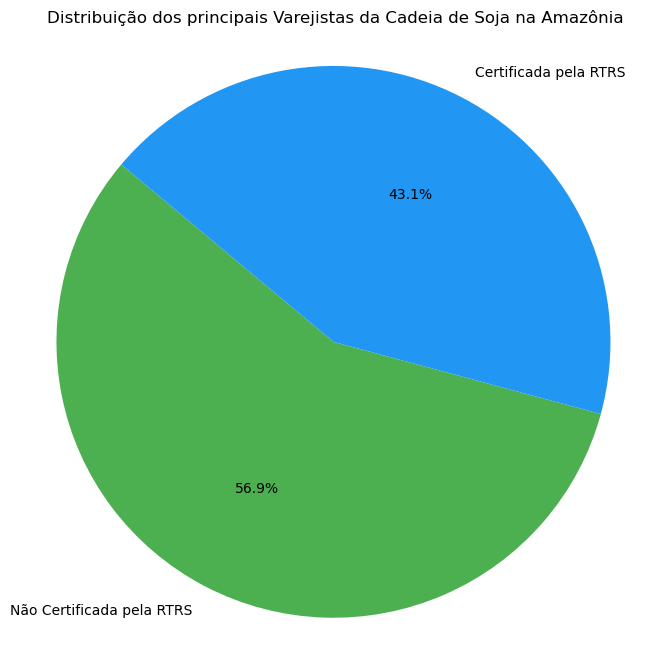

In [45]:
valores = [36326.0, 27517]
labels = ['Não Certificada pela RTRS', 'Certificada pela RTRS']
cores = ['#4CAF50', '#2196F3']  # Cores modernas

plt.figure(figsize=(8, 8))
plt.pie(valores, labels=labels, colors=cores, autopct='%1.1f%%', startangle=140)
plt.title('Distribuição dos principais Varejistas da Cadeia de Soja na Amazônia')
plt.axis('equal')  
plt.show()

 média da produção da soja das empresas certificadas é superior à média de produção exportada da soja não certificada pela RTRS.

Média Certificada: 2.453.566 (Milhões em USD) 


Média Não Certificada: 1.459.386 (Milhões em USD)


Média do Rendimento (Yield) Certificada: 189,36 ton/ha


Média do Rendimento (Yield) Não Certificada: 115,25 ton/ha

In [46]:
trase_consolidated = trase.groupby(['Group', 'IsRTRS']).agg({'SoyDefExp': 'mean', 
                                        'ExpFOB': 'mean',
                                        'CO2Gross': 'mean',
                                        'CO2Net': 'mean',
                                        'SoyTonnes': 'mean', 
                                        'LandUse':'mean',
                                        'SoyRisk': 'mean',
                                        'Yield': 'mean',
                                        }).reset_index()

In [47]:
trase_consolidated.head()

,Group,IsRTRS,SoyDefExp,ExpFOB,CO2Gross,CO2Net,SoyTonnes,LandUse,SoyRisk,Yield
0,1 TOQUE INDUSTRIA & COMERCIO DE ROUPAS LTDA ME,0,0.067115,1.824151e+04,20.278787,18.997381,5.270293e+01,14.983881,0.042747,3.470000
1,AB COMERCIO DE INSUMOS,0,0.059114,1.241996e+04,28.833882,27.558654,3.550443e+01,11.093733,0.035941,3.200405
2,ABJ COMERCIO AGRICOLA LTDA - EM RECUPERACAO JU...,0,7.896495,1.849163e+06,799.719869,654.797577,3.507100e+06,1412.364341,3.107626,1138.753333
3,ACO MINERACAO LIMITADA,0,0.175656,2.013581e+04,47.863579,44.445010,5.888204e+01,19.189679,0.073158,3.036000
4,ADAMI SA MADEIRAS,0,2.861906,1.803221e+05,437.510609,384.809503,2.995840e+02,98.556146,1.103949,3.016506


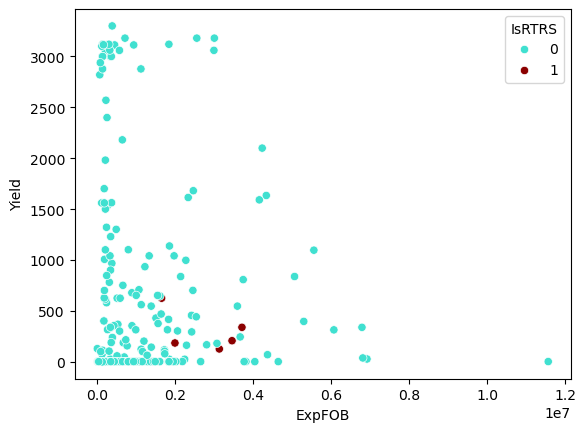

In [48]:
sns.scatterplot(data=trase_consolidated, x='ExpFOB', y='Yield', hue='IsRTRS', palette=palette)

plt.show()

## ANCOVA Analysis

A ANCOVA é usada para comparar uma variável dependente contínua entre dois ou mais grupos, levando em consideração a variabilidade de outras variáveis contínuas (covariáveis). O modelo estatístico básico para ANCOVA pode ser descrito como:

$$Y=\beta_0+\beta_1X_1+\beta_2X_2+...+\beta_kX_k+ϵ$$

Onde:

- $Y$ é a variável dependente (neste caso, FOB\_USD).
- $X_1,X_2,...,X_k$ são as covariáveis (outras variáveis numéricas contínuas).
- $\beta_0,\beta_1,...,\beta_k$ são os coeficientes a serem estimados.
- $\epsilon$ é o erro aleatório.

In [49]:
formula = 'SoyTonnes ~ IsRTRS + SoyDefExp + CO2Gross + CO2Net'

model = ols(formula, data=trase_consolidated).fit()

ancova_results = sm.stats.anova_lm(model, typ=2) # typ=2 para ANCOVA

print(ancova_results)

                 sum_sq     df         F    PR(>F)
IsRTRS     2.462265e+12    1.0  2.929083  0.087948
SoyDefExp  4.418297e+12    1.0  5.255956  0.022508
CO2Gross   4.611323e+12    1.0  5.485578  0.019775
CO2Net     4.623018e+12    1.0  5.499491  0.019621
Residual   2.740443e+14  326.0       NaN       NaN


## Constant Market Share (CMS)

In [50]:
trase.head()

,Group,SoyDefExp,ExpFOB,CO2Gross,SoyTonnes,LandUse,CO2Net,SoyRisk,IsRTRS,State,City,Year,Yield
0,DOMESTIC CONSUMPTION,0.0,0.000000,0.0,81.000000,27.000000,0.0,0.0,0,ACRE,CAPIXABA,2017,3.000
1,DOMESTIC CONSUMPTION,0.0,0.000000,0.0,1279.882771,496.078593,0.0,0.0,0,ACRE,CAPIXABA,2019,2.580
2,DOMESTIC CONSUMPTION,0.0,0.000000,0.0,1500.000000,480.000000,0.0,0.0,0,ACRE,CAPIXABA,2020,3.125
3,CARGILL,0.0,31812.773141,0.0,83.358068,26.049396,0.0,0.0,0,ACRE,CAPIXABA,2018,3.200
4,CARGILL,0.0,23971.251881,0.0,59.739949,18.668734,0.0,0.0,0,ACRE,CAPIXABA,2018,3.200


In [51]:
trase_consolidated = trase.groupby(['Year', 'Group', 'IsRTRS']).agg({'SoyDefExp': 'mean', 
                                        'ExpFOB': 'mean',
                                        'CO2Gross': 'mean',
                                        'CO2Net': 'mean',
                                        'SoyTonnes': 'mean', 
                                        'LandUse':'mean',
                                        'SoyRisk': 'mean',
                                        'Yield': 'mean',
                                        }).reset_index()

In [52]:
trase_consolidated['Year'].value_counts()


2019    192
2020    174
2006    110
2007    108
2005    103
2015     79
2018     77
2008     72
2017     67
2014     63
2010     62
2012     60
2009     59
2013     57
2016     54
2011     48
2004     36
Name: Year, dtype: int64

## Compute total FOB USD per Year and Market-Share

In [53]:
total_exports_by_year = trase_consolidated.groupby('Year')['SoyTonnes'].sum()

In [54]:
total_exports_by_year

Year
2004    5.117975e+07
2005    6.489762e+07
2006    3.865460e+07
2007    8.230717e+07
2008    5.270677e+07
2009    9.009241e+07
2010    6.612085e+07
2011    6.593203e+07
2012    7.100616e+07
2013    4.814070e+07
2014    6.194655e+07
2015    1.130143e+08
2016    6.239964e+07
2017    6.306104e+07
2018    6.110897e+07
2019    1.125433e+06
2020    2.342938e+06
Name: SoyTonnes, dtype: float64

<AxesSubplot:xlabel='Year'>

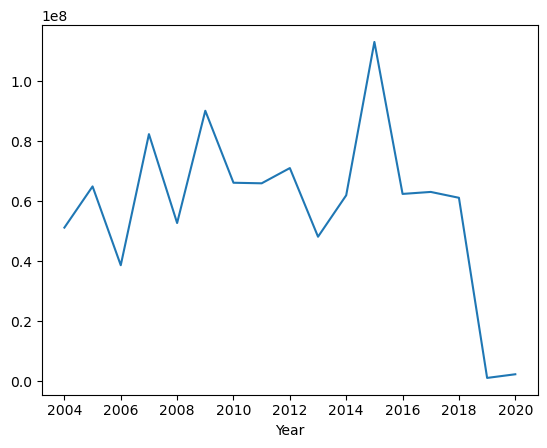

In [55]:
total_exports_by_year.plot()

In [56]:
trase_consolidated = trase_consolidated.merge(total_exports_by_year.rename('TotalExports'), on='Year')

In [57]:
trase_consolidated.head()

,Year,Group,IsRTRS,SoyDefExp,ExpFOB,CO2Gross,CO2Net,SoyTonnes,LandUse,SoyRisk,Yield,TotalExports
0,2004,ADAO JACOBOWSKI,0,NaN,1.231720e+05,NaN,NaN,4.000000e+02,148.148215,NaN,2.699999,5.117975e+07
1,2004,ADM,1,NaN,4.096963e+06,NaN,NaN,2.211301e+04,4920.237961,NaN,63.997773,5.117975e+07
2,2004,AGRENCO,0,NaN,3.578771e+06,NaN,NaN,9.591439e+05,4850.341320,NaN,210.227701,5.117975e+07
3,2004,AGRICOLA E PECUARIA MORRO AZUL,0,NaN,2.751788e+06,NaN,NaN,2.706085e+06,3660.079250,NaN,619.266695,5.117975e+07
4,2004,AGROMON AGRICULTURA E PECUARIA,0,NaN,4.241727e+05,NaN,NaN,1.638050e+03,650.020077,NaN,2.519999,5.117975e+07


In [58]:
# Calcular a produção total por status de certificação e ano
certified_production_by_year = trase_consolidated[trase_consolidated['IsRTRS'] == 1].groupby('Year')['SoyTonnes'].sum()
non_certified_production_by_year = trase_consolidated[trase_consolidated['IsRTRS'] == 0].groupby('Year')['SoyTonnes'].sum()

In [59]:
growth_rate_market = total_exports_by_year.pct_change().dropna()

In [60]:
growth_rate_market.tolist()

[0.26803330719547525,
 -0.40437565833566314,
 1.1292980768462186,
 -0.3596333437639323,
 0.7093137528211693,
 -0.2660774134486853,
 -0.002855681427146317,
 0.07695997822954936,
 -0.32202078800497524,
 0.28678134544734357,
 0.8243845839794093,
 -0.4478608594679635,
 0.010599448230637298,
 -0.03095525945160893,
 -0.9815831809453838,
 1.08181010654046]

In [61]:
anos = growth_rate_market.index.tolist()
crescimento = growth_rate_market.tolist()

In [62]:
# Inicializar listas para armazenar os resultados
market_expansion_effect = []
competitiveness_effect = []

# Calcular o efeito de expansão do mercado e o efeito de competitividade
for year in growth_rate_market.index[1:]:
    # Efeito de expansão do mercado para certificado e não certificado
    me_certified = growth_rate_market[year] * certified_production_by_year[year - 1]
    me_non_certified = growth_rate_market[year] * non_certified_production_by_year[year - 1]

    # Efeito de competitividade
    ce_certified = certified_production_by_year[year] - me_certified
    ce_non_certified = non_certified_production_by_year[year] - me_non_certified

    # Armazenar os resultados
    market_expansion_effect.append({'Year': year, 'Certified': me_certified, 'Non_certified': me_non_certified})
    competitiveness_effect.append({'Year': year, 'Certified': ce_certified, 'Non_certified': ce_non_certified})

df_market_expansion = pd.DataFrame(market_expansion_effect)
df_competitiveness = pd.DataFrame(competitiveness_effect)

# Exibir os resultados
print("Market Expansion Effect:")
print(df_market_expansion)
print("\nCompetitiveness Effect:")
print(df_competitiveness)

Market Expansion Effect:
    Year     Certified  Non_certified
0   2006 -4.809326e+04  -2.619493e+07
1   2007  8.677644e+05   4.278481e+07
2   2008 -1.012814e+06  -2.858759e+07
3   2009  4.650477e+06   3.273516e+07
4   2010 -5.005885e+06  -1.896567e+07
5   2011 -2.496996e+04  -1.638501e+05
6   2012  6.761360e+05   4.397992e+06
7   2013 -3.093905e+06  -1.977155e+07
8   2014  2.093811e+06   1.171204e+07
9   2015  7.161708e+06   4.390608e+07
10  2016 -2.988572e+06  -4.762613e+07
11  2017  8.517114e+04   5.762306e+05
12  2018 -1.897152e+05  -1.762356e+06
13  2019 -2.768407e+06  -5.721513e+07
14  2020  1.655328e+05   1.051972e+06

Competitiveness Effect:
    Year     Certified  Non_certified
0   2006  8.165037e+05   6.408112e+07
1   2007  1.948476e+06   3.670613e+07
2   2008  7.569118e+06   7.473806e+07
3   2009  1.416316e+07   3.854361e+07
4   2010  1.374984e+07   7.634256e+07
5   2011  8.810523e+06   5.731033e+07
6   2012  8.931646e+06   5.700039e+07
7   2013  1.039498e+07   6.061118e+07


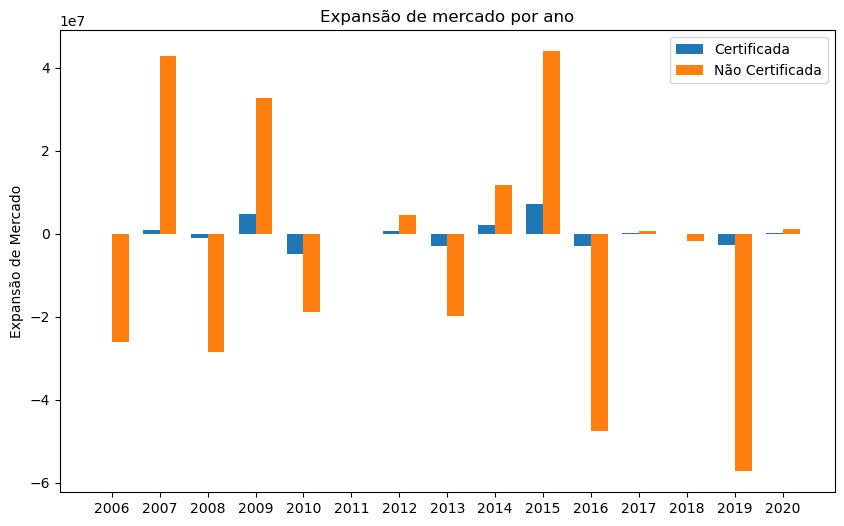

In [63]:
tamanho = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(df_market_expansion['Year']-tamanho/2, df_market_expansion['Certified'], tamanho, label = "Certificada")
bar2 = ax.bar(df_market_expansion['Year']+tamanho/2, df_market_expansion['Non_certified'], tamanho, label = "Não Certificada")

ax.set_ylabel('Expansão de Mercado')
ax.set_title('Expansão de mercado por ano')
ax.set_xticks(df_market_expansion['Year'])
ax.set_xticklabels(df_market_expansion['Year'])
ax.legend()
plt.savefig('expansao_mercado.png')
plt.show()

In [64]:
print(df_market_expansion['Certified'].sum())
print(df_market_expansion['Certified'].mean())
print(df_market_expansion['Certified'].var())

print(df_market_expansion['Non_certified'].sum())
print(df_market_expansion['Non_certified'].mean())
print(df_market_expansion['Non_certified'].var())

72245191227462.39 < 6639465219929285.0



568238.3424586344
37882.55616390896
9343988278280.197
-63122923.6564279
-4208194.910428527
894370046200465.8


True

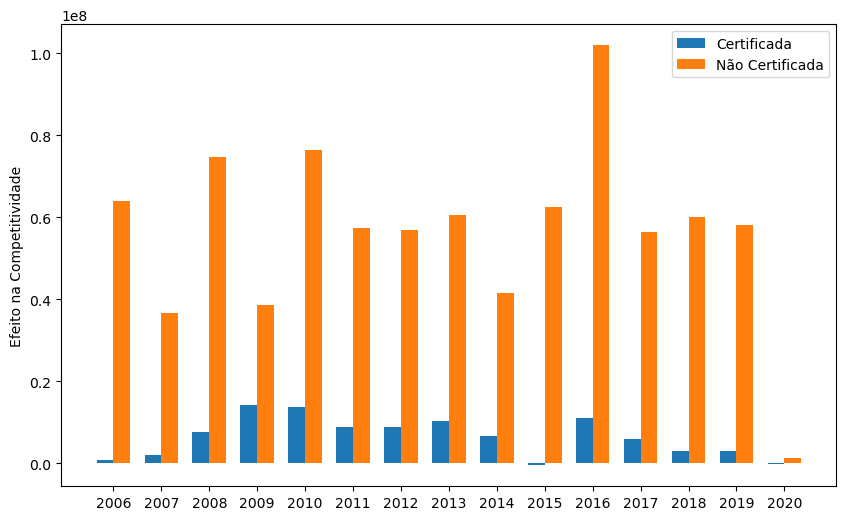

In [65]:
tamanho = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(df_competitiveness['Year']-tamanho/2, df_competitiveness['Certified'], tamanho, label = "Certificada")
bar2 = ax.bar(df_competitiveness['Year']+tamanho/2, df_competitiveness['Non_certified'], tamanho, label = "Não Certificada")

ax.set_ylabel('Efeito na Competitividade')
#ax.set_title('Efeito na competitividade por ano')
ax.set_xticks(df_competitiveness['Year'])
ax.set_xticklabels(df_competitiveness['Year'])
ax.legend()
plt.savefig('competitividade.png')
plt.show()

In [66]:
trase_consolidated.head()

,Year,Group,IsRTRS,SoyDefExp,ExpFOB,CO2Gross,CO2Net,SoyTonnes,LandUse,SoyRisk,Yield,TotalExports
0,2004,ADAO JACOBOWSKI,0,NaN,1.231720e+05,NaN,NaN,4.000000e+02,148.148215,NaN,2.699999,5.117975e+07
1,2004,ADM,1,NaN,4.096963e+06,NaN,NaN,2.211301e+04,4920.237961,NaN,63.997773,5.117975e+07
2,2004,AGRENCO,0,NaN,3.578771e+06,NaN,NaN,9.591439e+05,4850.341320,NaN,210.227701,5.117975e+07
3,2004,AGRICOLA E PECUARIA MORRO AZUL,0,NaN,2.751788e+06,NaN,NaN,2.706085e+06,3660.079250,NaN,619.266695,5.117975e+07
4,2004,AGROMON AGRICULTURA E PECUARIA,0,NaN,4.241727e+05,NaN,NaN,1.638050e+03,650.020077,NaN,2.519999,5.117975e+07


In [67]:
trase_consolidated['MarketShare'] = trase_consolidated['SoyTonnes'] / trase_consolidated['TotalExports'] * 100

In [68]:
trase_consolidated.sort_values(by=['Group', 'Year'], inplace=True)  # Garantir que os dados estejam ordenados

In [69]:
trase_consolidated['ExpectedExports'] = trase_consolidated.groupby('Group')['MarketShare'].shift(1) / 100 * trase_consolidated['TotalExports'].values
trase_consolidated['ExpectedExports'] = trase_consolidated['ExpectedExports'].fillna(0)  # Substitua NaN por 0 para o primeiro ano de cada empresa

In [70]:
trase_consolidated['Performance'] = trase_consolidated['SoyTonnes'] - trase_consolidated['ExpectedExports']

In [71]:
trase_consolidated.head()

,Year,Group,IsRTRS,SoyDefExp,ExpFOB,CO2Gross,CO2Net,SoyTonnes,LandUse,SoyRisk,Yield,TotalExports,MarketShare,ExpectedExports,Performance
1247,2020,1 TOQUE INDUSTRIA & COMERCIO DE ROUPAS LTDA ME,0,0.067115,1.824151e+04,20.278787,18.997381,5.270293e+01,14.983881,0.042747,3.470000,2.342938e+06,0.002249,0.0,5.270293e+01
1248,2020,AB COMERCIO DE INSUMOS,0,0.059114,1.241996e+04,28.833882,27.558654,3.550443e+01,11.093733,0.035941,3.200405,2.342938e+06,0.001515,0.0,3.550443e+01
978,2018,ABJ COMERCIO AGRICOLA LTDA - EM RECUPERACAO JU...,0,7.896495,1.849163e+06,799.719869,654.797577,3.507100e+06,1412.364341,3.107626,1138.753333,6.110897e+07,5.739093,0.0,3.507100e+06
1055,2019,ACO MINERACAO LIMITADA,0,0.175656,2.013581e+04,47.863579,44.445010,5.888204e+01,19.189679,0.073158,3.036000,1.125433e+06,0.005232,0.0,5.888204e+01
1056,2019,ADAMI SA MADEIRAS,0,2.861906,1.803221e+05,437.510609,384.809503,2.995840e+02,98.556146,1.103949,3.016506,1.125433e+06,0.026619,0.0,2.995840e+02


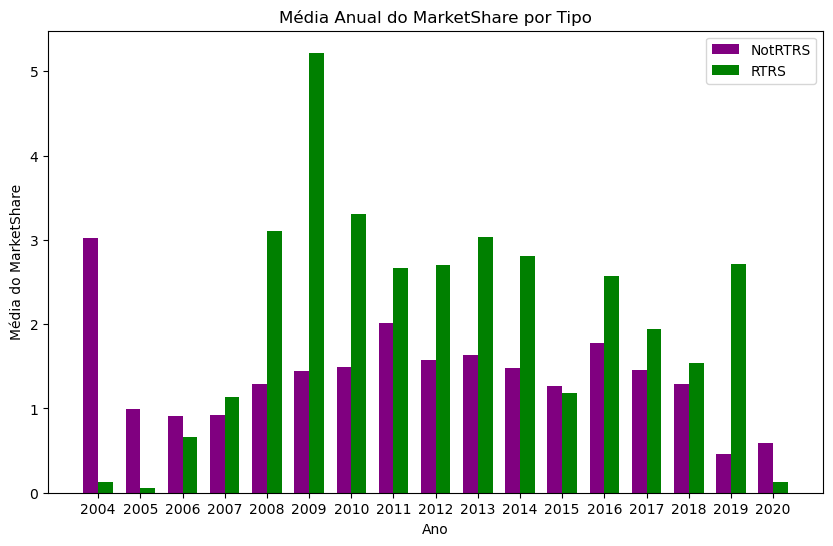

In [72]:
NotRTRS = trase_consolidated[trase_consolidated['IsRTRS'] == 0]
RTRS = trase_consolidated[trase_consolidated['IsRTRS'] == 1]

average_marketshare_by_year_NotRTRS = NotRTRS.groupby('Year')['MarketShare'].mean()
average_marketshare_by_year_RTRS = RTRS.groupby('Year')['MarketShare'].mean()

years = average_marketshare_by_year_NotRTRS.index
n_groups = len(years)
index = np.arange(n_groups)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars_NotRTRS = ax.bar(index - bar_width/2, average_marketshare_by_year_NotRTRS, bar_width, label='NotRTRS', color='purple')
bars_RTRS = ax.bar(index + bar_width/2, average_marketshare_by_year_RTRS, bar_width, label='RTRS', color='green')

ax.set_xlabel('Ano')
ax.set_ylabel('Média do MarketShare')
ax.set_title('Média Anual do MarketShare por Tipo')
ax.set_xticks(index)
ax.set_xticklabels(years)
ax.legend()

plt.show()

In [73]:
average_marketshare_by_year_NotRTRS

Year
2004    3.019195
2005    0.998167
2006    0.916001
2007    0.919794
2008    1.287659
2009    1.438498
2010    1.496134
2011    2.015694
2012    1.572165
2013    1.631421
2014    1.482346
2015    1.271560
2016    1.778013
2017    1.456151
2018    1.288983
2019    0.462053
2020    0.587834
Name: MarketShare, dtype: float64

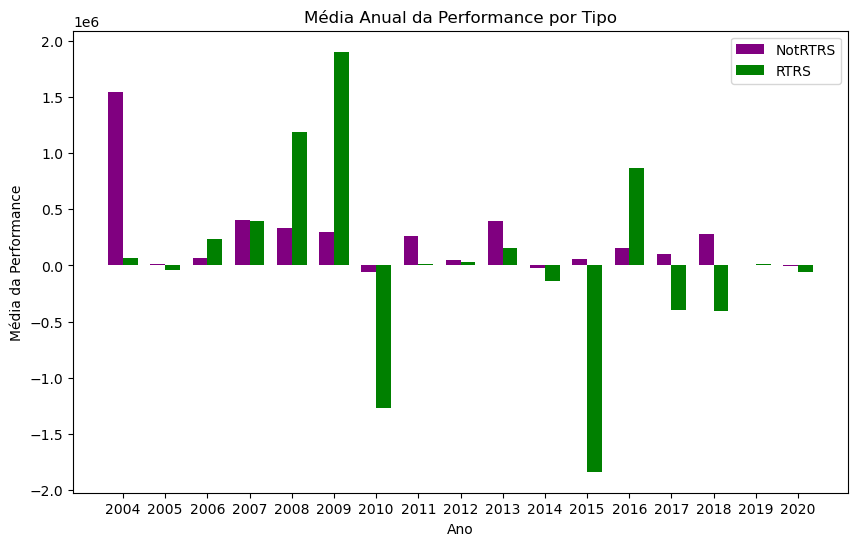

In [74]:
NotRTRS = trase_consolidated[trase_consolidated['IsRTRS'] == 0]
RTRS = trase_consolidated[trase_consolidated['IsRTRS'] == 1]

average_marketshare_by_year_NotRTRS = NotRTRS.groupby('Year')['Performance'].mean()
average_marketshare_by_year_RTRS = RTRS.groupby('Year')['Performance'].mean()

years = average_marketshare_by_year_NotRTRS.index 
n_groups = len(years)
index = np.arange(n_groups)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars_NotRTRS = ax.bar(index - bar_width/2, average_marketshare_by_year_NotRTRS, bar_width, label='NotRTRS', color='purple')
bars_RTRS = ax.bar(index + bar_width/2, average_marketshare_by_year_RTRS, bar_width, label='RTRS', color='green')

ax.set_xlabel('Ano')
ax.set_ylabel('Média da Performance')
ax.set_title('Média Anual da Performance por Tipo')
ax.set_xticks(index)
ax.set_xticklabels(years)
ax.legend()

plt.show()

In [75]:
print(average_marketshare_by_year_NotRTRS.sum())
print(average_marketshare_by_year_RTRS.sum())

average_marketshare_by_year_RTRS.sum() < average_marketshare_by_year_NotRTRS.sum()

3862798.6425910825
715617.2285635647


True

## CSM para exportação FOB

In [76]:
certified_production_by_year = trase_consolidated[trase_consolidated['IsRTRS'] == 1].groupby('Year')['ExpFOB'].sum()
non_certified_production_by_year = trase_consolidated[trase_consolidated['IsRTRS'] == 0].groupby('Year')['ExpFOB'].sum()

In [77]:
growth_rate_market = total_exports_by_year.pct_change().dropna()

In [78]:
market_expansion_effect = []
competitiveness_effect = []

# Calcular o efeito de expansão do mercado e o efeito de competitividade
for year in growth_rate_market.index[1:]:
    # Efeito de expansão do mercado para certificado e não certificado
    me_certified = growth_rate_market[year] * certified_production_by_year[year - 1]
    me_non_certified = growth_rate_market[year] * non_certified_production_by_year[year - 1]

    # Efeito de competitividade
    ce_certified = certified_production_by_year[year] - me_certified
    ce_non_certified = non_certified_production_by_year[year] - me_non_certified

    # Armazenar os resultados
    market_expansion_effect.append({'Year': year, 'Certified': me_certified, 'Non_certified': me_non_certified})
    competitiveness_effect.append({'Year': year, 'Certified': ce_certified, 'Non_certified': ce_non_certified})

df_market_expansion = pd.DataFrame(market_expansion_effect)
df_competitiveness = pd.DataFrame(competitiveness_effect)

# Exibir os resultados
print("Market Expansion Effect:")
print(df_market_expansion)
print("\nCompetitiveness Effect:")
print(df_competitiveness)

Market Expansion Effect:
    Year     Certified  Non_certified
0   2006 -3.020217e+06  -2.681294e+07
1   2007  1.167130e+07   8.957032e+07
2   2008 -2.984927e+06  -3.388233e+07
3   2009  1.521067e+07   5.979183e+07
4   2010 -4.946092e+06  -2.602921e+07
5   2011 -6.624741e+04  -3.201188e+05
6   2012  1.794940e+06   8.234217e+06
7   2013 -7.523840e+06  -8.487823e+07
8   2014  6.451872e+06   5.393450e+07
9   2015  1.804086e+07   1.433532e+08
10  2016 -7.327352e+06  -8.045651e+07
11  2017  1.343967e+05   1.309904e+06
12  2018 -4.631175e+05  -5.473177e+06
13  2019 -1.124969e+07  -1.976142e+08
14  2020  4.648291e+06   5.170505e+07

Competitiveness Effect:
    Year     Certified  Non_certified
0   2006  1.335522e+07   1.061280e+08
1   2007 -3.371385e+06   4.643231e+06
2   2008  2.442913e+07   1.181777e+08
3   2009  3.378254e+06   3.803388e+07
4   2010  2.814455e+07   1.381281e+08
5   2011  2.338928e+07   1.073136e+08
6   2012  2.156951e+07   2.553457e+08
7   2013  3.002137e+07   2.729466e+08


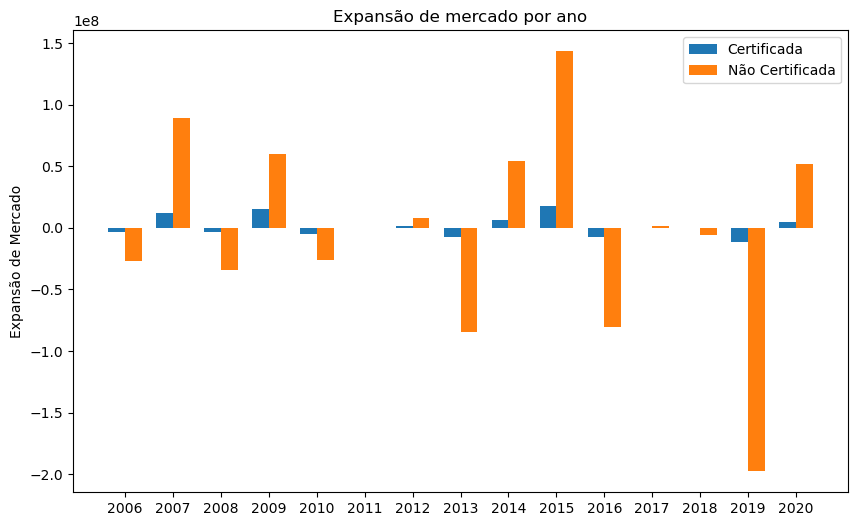

In [79]:
tamanho = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(df_market_expansion['Year']-tamanho/2, df_market_expansion['Certified'], tamanho, label = "Certificada")
bar2 = ax.bar(df_market_expansion['Year']+tamanho/2, df_market_expansion['Non_certified'], tamanho, label = "Não Certificada")

ax.set_ylabel('Expansão de Mercado')
ax.set_title('Expansão de mercado por ano')
ax.set_xticks(df_market_expansion['Year'])
ax.set_xticklabels(df_market_expansion['Year'])
ax.legend()

plt.show()

In [80]:
print(df_market_expansion['Certified'].sum())
print(df_market_expansion['Non_certified'].sum())

20370855.442195807
-47567750.99355527


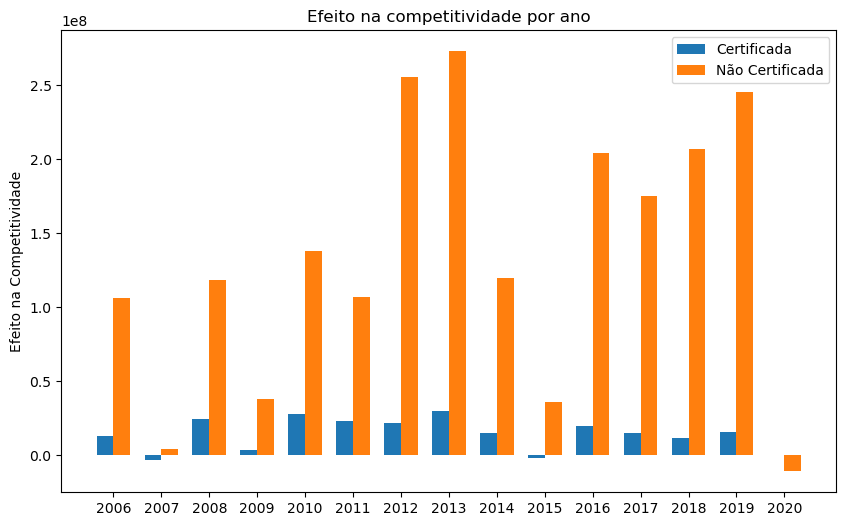

In [81]:
tamanho = 0.35
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(df_competitiveness['Year']-tamanho/2, df_competitiveness['Certified'], tamanho, label = "Certificada")
bar2 = ax.bar(df_competitiveness['Year']+tamanho/2, df_competitiveness['Non_certified'], tamanho, label = "Não Certificada")

ax.set_ylabel('Efeito na Competitividade')
ax.set_title('Efeito na competitividade por ano')
ax.set_xticks(df_competitiveness['Year'])
ax.set_xticklabels(df_competitiveness['Year'])
ax.legend()

plt.show()

In [82]:
total_exports_by_year = trase_consolidated.groupby('Year')['ExpFOB'].sum()
trase_consolidated = trase_consolidated.merge(total_exports_by_year.rename('TotalExportsFOB'), on='Year')
trase_consolidated['MarketShare'] = trase_consolidated['ExpFOB'] / trase_consolidated['TotalExportsFOB'] * 100

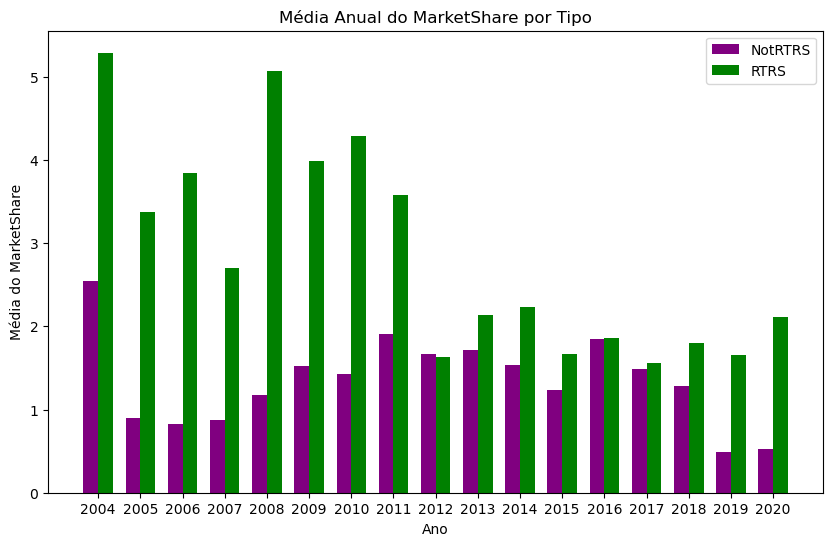

In [83]:
NotRTRS = trase_consolidated[trase_consolidated['IsRTRS'] == 0]
RTRS = trase_consolidated[trase_consolidated['IsRTRS'] == 1]

average_marketshare_by_year_NotRTRS = NotRTRS.groupby('Year')['MarketShare'].mean()
average_marketshare_by_year_RTRS = RTRS.groupby('Year')['MarketShare'].mean()

years = average_marketshare_by_year_NotRTRS.index
n_groups = len(years)
index = np.arange(n_groups)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars_NotRTRS = ax.bar(index - bar_width/2, average_marketshare_by_year_NotRTRS, bar_width, label='NotRTRS', color='purple')
bars_RTRS = ax.bar(index + bar_width/2, average_marketshare_by_year_RTRS, bar_width, label='RTRS', color='green')

ax.set_xlabel('Ano')
ax.set_ylabel('Média do MarketShare')
ax.set_title('Média Anual do MarketShare por Tipo')
ax.set_xticks(index)
ax.set_xticklabels(years)
ax.legend()

plt.show()

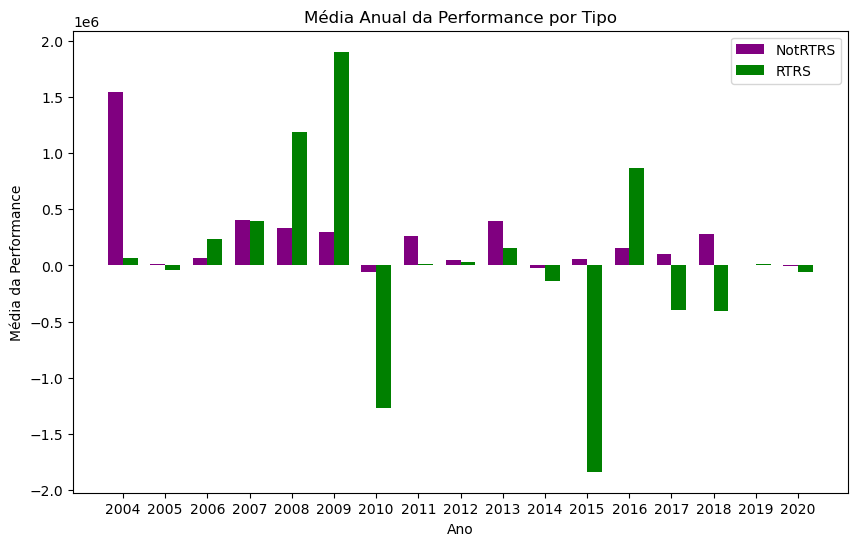

In [84]:
NotRTRS = trase_consolidated[trase_consolidated['IsRTRS'] == 0]
RTRS = trase_consolidated[trase_consolidated['IsRTRS'] == 1]

average_marketshare_by_year_NotRTRS = NotRTRS.groupby('Year')['Performance'].mean()
average_marketshare_by_year_RTRS = RTRS.groupby('Year')['Performance'].mean()

years = average_marketshare_by_year_NotRTRS.index 
n_groups = len(years)
index = np.arange(n_groups)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars_NotRTRS = ax.bar(index - bar_width/2, average_marketshare_by_year_NotRTRS, bar_width, label='NotRTRS', color='purple')
bars_RTRS = ax.bar(index + bar_width/2, average_marketshare_by_year_RTRS, bar_width, label='RTRS', color='green')

ax.set_xlabel('Ano')
ax.set_ylabel('Média da Performance')
ax.set_title('Média Anual da Performance por Tipo')
ax.set_xticks(index)
ax.set_xticklabels(years)
ax.legend()

plt.show()

In [85]:
print(average_marketshare_by_year_NotRTRS.sum())
print(average_marketshare_by_year_RTRS.sum())

print(average_marketshare_by_year_NotRTRS.sum() < average_marketshare_by_year_RTRS.sum())

3862798.6425910825
715617.2285635647
False


In [86]:
ts_notrtrs = NotRTRS.groupby('Year').agg({'ExpFOB': 'sum'}).reset_index()

In [87]:
ts_rtrs = RTRS.groupby('Year').agg({'ExpFOB': 'sum'}).reset_index()

In [88]:
ts_total = pd.merge(ts_notrtrs, ts_rtrs, on='Year', how='inner')

In [89]:
ts_total

,Year,ExpFOB_x,ExpFOB_y
0,2004,4.155968e+07,7.836561e+06
1,2005,6.630701e+07,7.468839e+06
2,2006,7.931504e+07,1.033501e+07
3,2007,9.421355e+07,8.299918e+06
4,2008,8.429532e+07,2.144420e+07
5,2009,9.782571e+07,1.858892e+07
6,2010,1.120989e+08,2.319846e+07
7,2011,1.069935e+08,2.332304e+07
8,2012,2.635800e+08,2.336446e+07
9,2013,1.880684e+08,2.249753e+07


In [90]:
ts_total['Percent'] = ts_total['ExpFOB_y'] / (ts_total['ExpFOB_x'] + ts_total['ExpFOB_y'])

In [91]:
ts_total['Percent']

0     0.158647
1     0.101237
2     0.115282
3     0.080964
4     0.202802
5     0.159679
6     0.171463
7     0.178972
8     0.081425
9     0.106843
10    0.111781
11    0.083470
12    0.093053
13    0.078015
14    0.053861
15    0.082485
16    0.105594
Name: Percent, dtype: float64

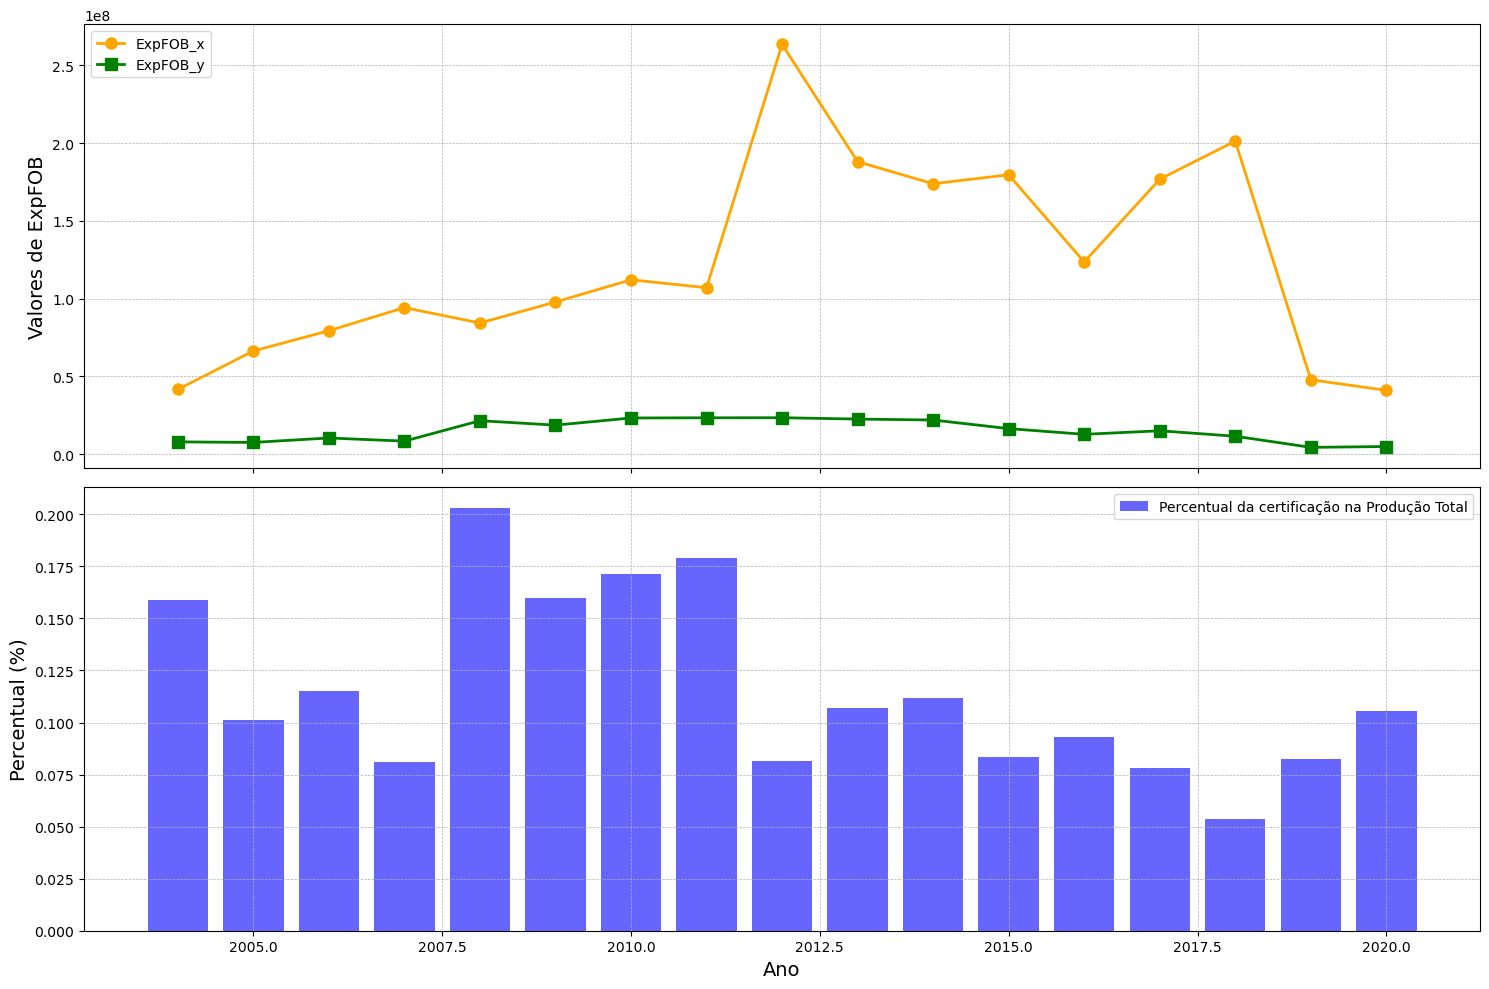

In [92]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[15,10], sharex=True)  # Gráficos compartilham o mesmo eixo X

# Gráfico de linha para ExpFOB_x e ExpFOB_y
ax1.plot(ts_total['Year'], ts_total['ExpFOB_x'], marker='o', color='orange', label='ExpFOB_x', linewidth=2, markersize=8)
ax1.plot(ts_total['Year'], ts_total['ExpFOB_y'], marker='s', color='green', label='ExpFOB_y', linewidth=2, markersize=8)
ax1.set_ylabel('Valores de ExpFOB', fontsize=14)  # Define o rótulo do eixo Y para os valores de ExpFOB
ax1.legend(loc='upper left')  # Posiciona a legenda
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adiciona grade ao gráfico

# Gráfico de barras para 'percent'
ax2.bar(ts_total['Year'], ts_total['Percent'], color='blue', alpha=0.6, label='Percentual da certificação na Produção Total')
ax2.set_xlabel('Ano', fontsize=14)  # Define o rótulo do eixo X
ax2.set_ylabel('Percentual (%)', fontsize=14)  # Define o rótulo do eixo Y para os valores percentuais
ax2.legend(loc='upper right')  # Posiciona a legenda
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adiciona grade ao gráfico

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()  # Mostra os gráficos

In [93]:
NotRTRS

,Year,Group,IsRTRS,SoyDefExp,ExpFOB,CO2Gross,CO2Net,SoyTonnes,LandUse,SoyRisk,Yield,TotalExports,MarketShare,ExpectedExports,Performance,TotalExportsFOB
0,2020,1 TOQUE INDUSTRIA & COMERCIO DE ROUPAS LTDA ME,0,0.067115,1.824151e+04,20.278787,18.997381,5.270293e+01,14.983881,0.042747,3.470000,2.342938e+06,0.039818,0.000000e+00,5.270293e+01,4.581242e+07
1,2020,AB COMERCIO DE INSUMOS,0,0.059114,1.241996e+04,28.833882,27.558654,3.550443e+01,11.093733,0.035941,3.200405,2.342938e+06,0.027110,0.000000e+00,3.550443e+01,4.581242e+07
2,2020,ADECOAGRO,0,3.145789,2.125392e+05,1608.578773,1540.483571,6.076299e+02,177.070522,1.962703,3.571667,2.342938e+06,0.463934,1.491882e+03,-8.842525e+02,4.581242e+07
4,2020,AFG BRASIL,0,1.479514,9.115094e+05,307.081464,279.380782,2.592708e+03,709.809616,1.024859,3.617600,2.342938e+06,1.989655,6.160459e+03,-3.567751e+03,4.581242e+07
5,2020,AGRALE SA,0,20.287330,1.460805e+05,3305.508328,2933.235817,4.644384e+02,142.853017,18.024182,3.251163,2.342938e+06,0.318867,0.000000e+00,4.644384e+02,4.581242e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416,2017,SODRUGESTVO,0,103.824434,2.203908e+07,51277.004013,49031.989595,5.473651e+04,15991.507915,49.472467,3.393000,6.306104e+07,11.492444,1.126292e+06,-1.071555e+06,1.917701e+08
1417,2017,USINA FRUTAL ACUCAR E ALCOOL,0,0.539235,3.331758e+05,111.322256,101.427293,1.154365e+03,399.838946,0.338511,2.887076,6.306104e+07,0.173737,2.796923e+04,-2.681486e+04,1.917701e+08
1418,2017,USINA PETRIBU SA,0,200.657141,8.524809e+05,30644.206328,26962.147793,2.243789e+03,732.830077,101.156326,2.905083,6.306104e+07,0.444533,7.503706e+02,1.493418e+03,1.917701e+08
1419,2017,USINA SAO JOSE,0,148.143427,6.462396e+05,22361.219210,19642.787319,1.632948e+03,523.380833,73.432481,3.120000,6.306104e+07,0.336987,0.000000e+00,1.632948e+03,1.917701e+08


In [94]:
ts_notrtrs = NotRTRS.groupby('Year').agg({'SoyTonnes': 'sum', 'LandUse': 'sum'}).reset_index()
ts_notrtrs['Income'] = ts_notrtrs['SoyTonnes'] / ts_notrtrs['LandUse']
ts_rtrs = RTRS.groupby('Year').agg({'SoyTonnes': 'sum', 'LandUse': 'sum'}).reset_index()
ts_rtrs['Income'] = ts_rtrs['SoyTonnes'] / ts_rtrs['LandUse']

In [95]:
ts_notrtrs

,Year,SoyTonnes,LandUse,Income
0,2004,5.099215e+07,8.129747e+04,627.229219
1,2005,6.477869e+07,1.132472e+05,572.011612
2,2006,3.788619e+07,7.129643e+05,53.138978
3,2007,7.949093e+07,2.143118e+06,37.091258
4,2008,4.615047e+07,3.622805e+05,127.388762
5,2009,7.127877e+07,1.615490e+05,441.220583
6,2010,5.737689e+07,1.321706e+05,434.112471
7,2011,5.714648e+07,1.494104e+06,38.247984
8,2012,6.139838e+07,1.583101e+06,38.783603
9,2013,4.083963e+07,4.106996e+06,9.943917


In [128]:
def calcular_taxas_crescimento_anual(dados, coluna=None):
    """
    Calcula as taxas de crescimento anual para uma coluna especificada em um DataFrame
    ou para uma lista de valores.
    
    :param dados: DataFrame do pandas ou lista de valores.
    :param coluna: (Opcional) Nome da coluna para a qual calcular as taxas de crescimento, se dados for um DataFrame.
    :return: Uma lista contendo as taxas de crescimento anual.
    """
    taxas_crescimento = []
    
    # Se 'dados' for um DataFrame, utiliza a coluna especificada.
    if isinstance(dados, pd.DataFrame) and coluna is not None:
        valores = dados[coluna].values
    elif isinstance(dados, list):
        valores = dados
    else:
        raise ValueError("Os dados devem ser um DataFrame do pandas com uma coluna especificada ou uma lista de valores.")
    
    for i in range(1, len(valores)):
        valor_atual = valores[i]
        valor_anterior = valores[i - 1]
        taxa_crescimento = ((valor_atual - valor_anterior) / valor_anterior) * 100
        taxas_crescimento.append(taxa_crescimento)
    
    return taxas_crescimento

In [129]:
ts_notrtrs['Tx_Producao'] = [None] + calcular_taxas_crescimento_anual(ts_notrtrs, 'SoyTonnes')
ts_notrtrs['Tx_Produtividade'] = [None] + calcular_taxas_crescimento_anual(ts_notrtrs, 'Income')
ts_rtrs['Tx_Producao'] = [None] + calcular_taxas_crescimento_anual(ts_rtrs, 'SoyTonnes')
ts_rtrs['Tx_Produtividade'] = [None] + calcular_taxas_crescimento_anual(ts_rtrs, 'Income')

ts_producao_total_cadeia = ts_notrtrs['SoyTonnes'] + ts_rtrs['SoyTonnes']
ts_producao_total_cadeia= ts_producao_total_cadeia.to_list()
ts_producao_tx_total_cadeia = calcular_taxas_crescimento_anual(ts_producao_total_cadeia)

In [131]:
p0_producao_notrtrs = ts_notrtrs['Tx_Producao'].iloc[:10].mean()
p1_producao_notrtrs = ts_notrtrs['Tx_Producao'].iloc[10:].mean()

p0_producao_rtrs = ts_rtrs['Tx_Producao'].iloc[:10].mean()
p1_producao_rtrs = ts_rtrs['Tx_Producao'].iloc[10:].mean()

p0_producao_amazonia = np.mean(ts_producao_tx_total_cadeia[10:])
p1_producao_amazonia = np.mean(ts_producao_tx_total_cadeia[:10])

p0_produtividade_rtrs = ts_rtrs['Tx_Produtividade'].iloc[10:].mean()
p1_produtividade_rtrs = ts_rtrs['Tx_Produtividade'].iloc[:10].mean()

p0_produtividade_notrtrs = ts_notrtrs['Tx_Produtividade'].iloc[10:].mean()
p1_produtividade_notrtrs = ts_notrtrs['Tx_Produtividade'].iloc[:10].mean()

print(f'Produção em periodo 0 da NOTRTRS: {p0_producao_notrtrs:.2f}')
print(f'Produção em periodo 1 da NOTRTRS: {p1_producao_notrtrs:.2f}')

print(f'Produção em periodo 0 da RTRS: {p0_producao_rtrs:.2f}')
print(f'Produção em periodo 1 da RTRS: {p1_producao_rtrs:.2f}')

print(f'Produção em periodo 0 da amazonia: {p0_producao_amazonia:.2f}')
print(f'Produção em periodo 1 da amazonia: {p1_producao_amazonia:.2f}')

print(f'Produtividade em periodo 0 da NOTRTRS: {p0_produtividade_notrtrs:.2f}')
print(f'Produtividade em periodo 1 da NOTRTRS: {p1_produtividade_notrtrs:.2f}')

print(f'Produtividade em periodo 0 da RTRS: {p0_produtividade_rtrs:.2f}')
print(f'Produtividade em periodo 1 da RTRS: {p1_produtividade_rtrs:.2f}')

Produção em periodo 0 da NOTRTRS: 6.88
Produção em periodo 1 da NOTRTRS: 18.48
Produção em periodo 0 da RTRS: 114.23
Produção em periodo 1 da RTRS: -35.15
Produção em periodo 0 da amazonia: 7.61
Produção em periodo 1 da amazonia: 11.15
Produtividade em periodo 0 da NOTRTRS: 723.46
Produtividade em periodo 1 da NOTRTRS: 21.59
Produtividade em periodo 0 da RTRS: 348.35
Produtividade em periodo 1 da RTRS: 168.56


## calculus


In [97]:
# Calculando a variação total da produção (2011 a 2020) período 0 e 1
delta_v_certificada = sum(ts_rtrs["SoyTonnes"][7:]) - sum(ts_rtrs["SoyTonnes"][:7])
delta_v_nao_certificada = sum(ts_notrtrs["SoyTonnes"][7:]) - sum(ts_notrtrs["SoyTonnes"][:7])

# Calculando a produtividade média nos períodos 0 e 1 para cada tipo de soja
prod_med_certificada_p0 = sum(ts_rtrs["Income"][:7]) / 7
prod_med_certificada_p1 = sum(ts_rtrs["Income"][7:]) / 10
prod_med_nao_certificada_p0 = sum(ts_notrtrs["Income"][:7]) / 7
prod_med_nao_certificada_p1 = sum(ts_notrtrs["Income"][7:]) / 10

# Efeito de Produtividade (Epr) para ambos os tipos de soja, usando a formula fornecida: Epr = (p1/p0 - 1) * V0
# Onde V0 é a produção total no período 0
v0_certificada = sum(ts_rtrs["SoyTonnes"][:7])
v0_nao_certificada = sum(ts_notrtrs["SoyTonnes"][:7])
epr_certificada = ((prod_med_certificada_p1 / prod_med_certificada_p0) - 1) * v0_certificada
epr_nao_certificada = ((prod_med_nao_certificada_p1 / prod_med_nao_certificada_p0) - 1) * v0_nao_certificada

# Como não temos dados explícitos para calcular o Exr (Efeito de Expansão do Mercado) diretamente,
# assumiremos que é a parcela da variação total não explicada pelo Epr, 
# Ecr = DeltaV, então Exr = DeltaV - Epr, para simplificação neste contexto.
exr_certificada = delta_v_certificada - epr_certificada
exr_nao_certificada = delta_v_nao_certificada - epr_nao_certificada

# Ecr (Efeito de Competitividade Relativa) é igual a variação total, neste contexto simplificado
ecr_certificada = delta_v_certificada
ecr_nao_certificada = delta_v_nao_certificada

In [99]:
print(f'variação total da exportação (ton) certificada: {delta_v_certificada}') 
print(f'variação total da exportação (ton) não-certificada: {delta_v_nao_certificada}') 
print(f'produtividade (ton/ha) certificada: {epr_certificada}')
print(f'produtividade (ton/ha) não certificada: {epr_nao_certificada}') 

print(f'Efeito Expansão de Mercado (ton) certificada: {delta_v_certificada}') 
print(f'Efeito Expansão de Mercado (ton) nao-certificada: {delta_v_nao_certificada}') 

#exr_certificada, exr_nao_certificada, ecr_certificada, ecr_nao_certificada')


variação total da exportação (ton) certificada: 20202506.774916545
variação total da exportação (ton) não-certificada: 83916127.9221189
produtividade (ton/ha) certificada: 143754036.5981005
produtividade (ton/ha) não certificada: -233515761.49561986
Efeito Expansão de Mercado (ton) certificada: 20202506.774916545
Efeito Expansão de Mercado (ton) nao-certificada: 83916127.9221189


In [ ]:
# Calculando a produção total para os períodos 0 e 1

total_periodo_0 = ts_rtrs.loc[ts_rtrs["Year"] <= 2010, "SoyTonnes"].sum() + ts_notrtrs.loc[ts_notrtrs["Year"] <= 2010, "SoyTonnes"].sum()
total_periodo_1 = ts_rtrs.loc[ts_rtrs["Year"] <= 2020, "SoyTonnes"].sum() + ts_notrtrs.loc[ts_notrtrs["Year"] <= 2020, "SoyTonnes"].sum()

# Variação total da produção
delta_v = total_periodo_1 - total_periodo_0

# Taxa de crescimento do mercado
g = total_periodo_1 / total_periodo_0


# Variação absoluta para soja certificada e não certificada
delta_v_certificada = ts_rtrs["SoyTonnes"].sum() - ts_rtrs.loc[ts_rtrs["Year"] <= 2010, "SoyTonnes"].sum()
delta_v_nao_certificada = ts_notrtrs["SoyTonnes"].sum() - ts_notrtrs.loc[ts_notrtrs["Year"] <= 2010, "SoyTonnes"].sum()



In [ ]:
print(f'total_periodo_0, total_periodo_1, delta_v, g, delta_v_certificada, delta_v_nao_certificada')

445959174.02160907 996036982.7402534 550077808.7186444 2.2334712250857076 58207592.25125149 491870216.467393


In [ ]:
ts_notrtrs['LandUse'] = ts_notrtrs['LandUse'].astype(float)
ts_notrtrs['Income'] = NotRTRS['SoyTonnes'] / NotRTRS['LandUse']
ts_notrtrs.head()

,Year,SoyTonnes,LandUse,Income
0,2004,5.099215e+07,8.129747e+04,3.517309
1,2005,6.477869e+07,1.132472e+05,3.200405
2,2006,3.788619e+07,7.129643e+05,3.431570
3,2007,7.949093e+07,2.143118e+06,NaN
4,2008,4.615047e+07,3.622805e+05,3.652681


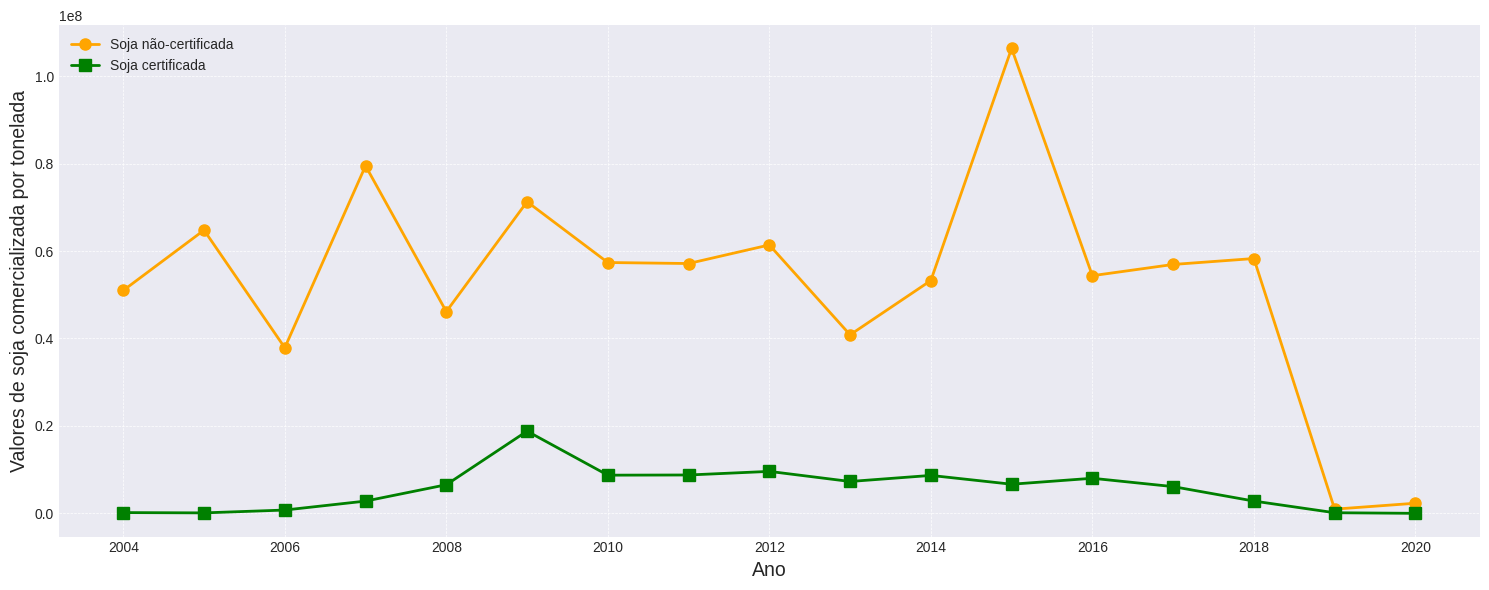

In [ ]:
fig, ax1 = plt.subplots(figsize=[15, 6])

# Gráfico de linha para SoyTonnes
ax1.plot(ts_total['Year'], ts_total['SoyTonnes_x'], marker='o', color='orange', label='Soja não-certificada', linewidth=2, markersize=8)
ax1.plot(ts_total['Year'], ts_total['SoyTonnes_y'], marker='s', color='green', label='Soja certificada', linewidth=2, markersize=8)
ax1.set_xlabel('Ano', fontsize=14)
ax1.set_ylabel('Valores de soja comercializada por tonelada', fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

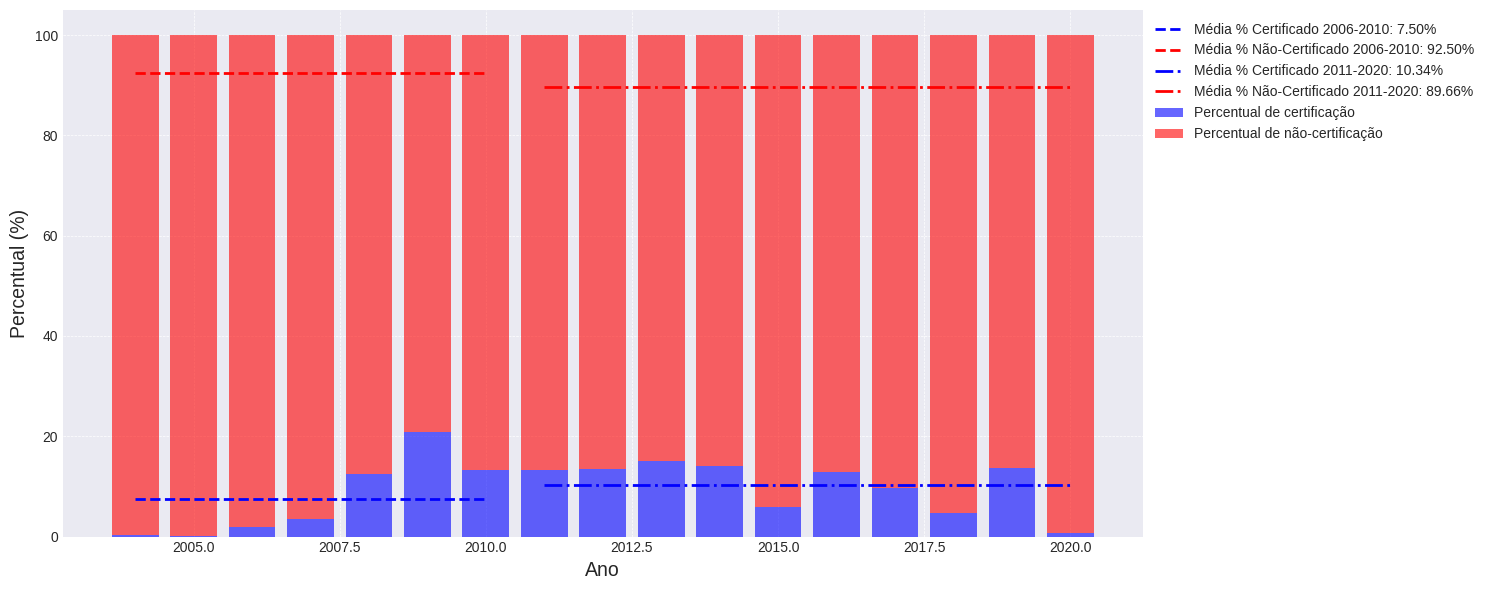

In [ ]:
# Calculando as médias dos percentuais para os dois períodos
media_percent_certificado_p1 = ts_total.loc[ts_total['Year'] <= 2010, 'Percent'].mean() * 100
media_percent_nao_certificado_p1 = ts_total.loc[ts_total['Year'] <= 2010, 'Non_cert_percent'].mean() * 100

media_percent_certificado_p2 = ts_total.loc[ts_total['Year'] > 2010, 'Percent'].mean() * 100
media_percent_nao_certificado_p2 = ts_total.loc[ts_total['Year'] > 2010, 'Non_cert_percent'].mean() * 100

# Adaptação para melhorar a posição da legenda e incluir os números das médias
fig, ax2 = plt.subplots(figsize=[15, 6])

# Gráfico de barras para 'Percent'
ax2.bar(ts_total['Year'], ts_total['Percent'] * 100, color='blue', alpha=0.6, label='Percentual de certificação')
ax2.bar(ts_total['Year'], ts_total['Non_cert_percent'] * 100, bottom=ts_total['Percent'] * 100, color='red', alpha=0.6, label='Percentual de não-certificação')

# Adicionando linhas das médias para os períodos específicos com valores nas legendas
ax2.hlines(media_percent_certificado_p1, anos_p1.iloc[0], anos_p1.iloc[-1], colors='blue', linestyles='--', linewidth=2, label=f'Média % Certificado 2006-2010: {media_percent_certificado_p1:.2f}%')
ax2.hlines(media_percent_nao_certificado_p1, anos_p1.iloc[0], anos_p1.iloc[-1], colors='red', linestyles='--', linewidth=2, label=f'Média % Não-Certificado 2006-2010: {media_percent_nao_certificado_p1:.2f}%')
ax2.hlines(media_percent_certificado_p2, anos_p2.iloc[0], anos_p2.iloc[-1], colors='blue', linestyles='-.', linewidth=2, label=f'Média % Certificado 2011-2020: {media_percent_certificado_p2:.2f}%')
ax2.hlines(media_percent_nao_certificado_p2, anos_p2.iloc[0], anos_p2.iloc[-1], colors='red', linestyles='-.', linewidth=2, label=f'Média % Não-Certificado 2011-2020: {media_percent_nao_certificado_p2:.2f}%')

ax2.set_xlabel('Ano', fontsize=14)
ax2.set_ylabel('Percentual (%)', fontsize=14)

# Melhorando a posição da legenda e colocando-a fora do gráfico
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('percentual_market_share.png')
plt.show()



In [ ]:
rtrs_data[['Total_Farm_Area', 'Total_Production']].describe()

,Total_Production
count,128.000000
mean,120267.911328
std,156956.570066
min,102.800000
25%,7469.000000
50%,49167.265000
75%,197840.377500
max,723435.470000


In [ ]:
import re

rtrs_data['Total_Farm_Area'] = rtrs_data['Total_Farm_Area'].apply(lambda x: re.sub(',', '.', x))


In [ ]:
rtrs_data['Total_Farm_Area'] = rtrs_data['Total_Farm_Area'].astype(float)

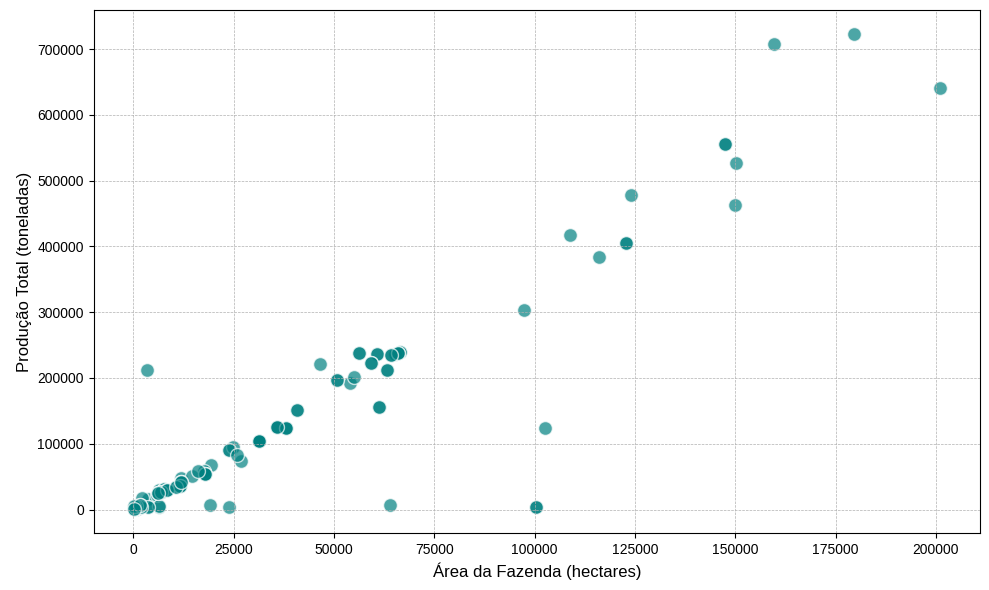

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(rtrs_data['Total_Farm_Area'], rtrs_data['Total_Production'], c='teal', alpha=0.7, edgecolors='w', s=100)

#plt.title('Relação entre Produção Total e Área da Fazenda', fontsize=15, fontweight='bold')
plt.xlabel('Área da Fazenda (hectares)', fontsize=12)
plt.ylabel('Produção Total (toneladas)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Adicionando um estilo moderno ao gráfico
plt.style.use('seaborn-darkgrid')
plt.savefig('Relação entre Produção Total e Área da Fazenda.png')
plt.show()

In [ ]:
RTRS['Group'].value_counts()

ADM                       17
AMAGGI                    17
BUNGE                     17
BOM JESUS AGROPECUARIA    12
GIRASSOL AGRICOLA          9
Name: Group, dtype: int64

In [ ]:
ts_general = trase_consolidated.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()

In [ ]:
len(ts_general)

17

In [ ]:
ts_general['Year'] = ts_general['Year'].apply(lambda x: 0 if x < 2012 else 1)

In [ ]:
ts_general_split = ts_general.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()

In [ ]:
ts_general_split

,Year,SoyTonnes
0,0,5.118912e+08
1,1,4.841458e+08


In [ ]:
taxa_crescimento_geral = ((4.841458e+08 - 5.118912e+08) / 5.118912e+08) * 100
print(f'Taxa de crescimento geral: {taxa_crescimento_geral}%')

Taxa de crescimento geral: -5.420175224735256%


In [ ]:
NotRTRS = trase_consolidated[trase_consolidated['IsRTRS'] == 0]
RTRS = trase_consolidated[trase_consolidated['IsRTRS'] == 1]

In [ ]:
NotRTRS.head()

,Year,Group,IsRTRS,SoyDefExp,ExpFOB,CO2Gross,CO2Net,SoyTonnes,LandUse,SoyRisk,Yield,TotalExports,MarketShare,ExpectedExports,Performance,TotalExportsFOB
0,2020,1 TOQUE INDUSTRIA & COMERCIO DE ROUPAS LTDA ME,0,0.067115,18241.507656,20.278787,18.997381,52.702934,14.983881,0.042747,3.470000,2.342938e+06,0.039818,0.000000,52.702934,4.581242e+07
1,2020,AB COMERCIO DE INSUMOS,0,0.059114,12419.958460,28.833882,27.558654,35.504434,11.093733,0.035941,3.200405,2.342938e+06,0.027110,0.000000,35.504434,4.581242e+07
2,2020,ADECOAGRO,0,3.145789,212539.228547,1608.578773,1540.483571,607.629866,177.070522,1.962703,3.571667,2.342938e+06,0.463934,1491.882323,-884.252457,4.581242e+07
4,2020,AFG BRASIL,0,1.479514,911509.361197,307.081464,279.380782,2592.708324,709.809616,1.024859,3.617600,2.342938e+06,1.989655,6160.459086,-3567.750762,4.581242e+07
5,2020,AGRALE SA,0,20.287330,146080.532910,3305.508328,2933.235817,464.438414,142.853017,18.024182,3.251163,2.342938e+06,0.318867,0.000000,464.438414,4.581242e+07


In [ ]:
NotRTRS = NotRTRS.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()
RTRS = RTRS.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()

NotRTRS['Year'] = NotRTRS['Year'].apply(lambda x: 0 if x < 2012 else 1)
RTRS['Year'] = RTRS['Year'].apply(lambda x: 0 if x < 2012 else 1)

In [ ]:
NotRTRS = NotRTRS.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()
RTRS = RTRS.groupby('Year').agg({'SoyTonnes': 'sum'}).reset_index()

In [ ]:
NotRTRS

,Year,SoyTonnes
0,0,4.651006e+08
1,1,4.347237e+08


In [ ]:
taxa_crescimento_not_rtrs = ((4.347237e+08 - 4.651006e+08) / 4.651006e+08) * 100
print(f'Taxa de crescimento geral da soja não certificada: {taxa_crescimento_geral}%')

Taxa de crescimento geral da soja não certificada: -5.420175224735256%


In [ ]:
RTRS

,Year,SoyTonnes
0,0,4.679064e+07
1,1,4.942204e+07


In [ ]:
taxa_crescimento_rtrs = ((4.942204e+07 - 4.679064e+07) / 4.679064e+07) * 100
print(f'Taxa de crescimento geral da soja certificada: {taxa_crescimento_rtrs}%')

Taxa de crescimento geral da soja certificada: 5.6237743275150756%


In [ ]:
diferenca = abs(taxa_crescimento_not_rtrs) - abs(taxa_crescimento_rtrs)
print(f'Diferença: {diferenca}')

Diferença: 0.9074793410460913
